In [8]:
# Import neccessarry libraries

import pandas as pd
import pm4py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

from catboost import CatBoostClassifier


In [1]:
import requests
url = "https://data.4tu.nl/ndownloader/items/35ed7122-966a-484e-a0e1-749b64e3366d/versions/1"
response = requests.get(url)
if response.status_code == 200:
    with open("BPI Challenge 2019_1_all.zip", "wb") as file:
        file.write(response.content)
        print("File downloaded successfully!")
else:
    print("Failed to download the file.")

File downloaded successfully!


In [3]:
import zipfile
import os

# Specify the name of the ZIP file
zip_file_name = "BPI Challenge 2019_1_all.zip"

# Create a ZipFile object
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    # Extract all the contents into the current directory
    zip_ref.extractall()

# Print a message to confirm extraction
print(f"{zip_file_name} has been extracted.")

BPI Challenge 2019_1_all.zip has been extracted.


In [9]:
# Read the .xes file
log = pm4py.read.read_xes("BPI_Challenge_2019.xes")
print(log.shape)
log.head()

C:\Users\legion\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|██████████| 251734/251734 [03:19<00:00, 1259.58it/s]


(1595923, 21)


User org:resource                         concept:name  \
0  batch_00     batch_00                         SRM: Created   
1  batch_00     batch_00                        SRM: Complete   
2  batch_00     batch_00               SRM: Awaiting Approval   
3  batch_00     batch_00              SRM: Document Completed   
4  batch_00     batch_00  SRM: In Transfer to Execution Syst.   

   Cumulative net worth (EUR)            time:timestamp case:Spend area text  \
0                       298.0 2018-01-02 12:53:00+00:00         CAPEX & SOCS   
1                       298.0 2018-01-02 13:53:00+00:00         CAPEX & SOCS   
2                       298.0 2018-01-02 13:53:00+00:00         CAPEX & SOCS   
3                       298.0 2018-01-02 13:53:00+00:00         CAPEX & SOCS   
4                       298.0 2018-01-02 13:53:00+00:00         CAPEX & SOCS   

     case:Company case:Document Type case:Sub spend area text  \
0  companyID_0000  EC Purchase order      Facility Management   
1  companyID_0000  EC Purchase order      Facility Management   
2  companyID_0000  EC Purchase order      Facility Management   
3  companyID_0000  EC Purchase order      Facility Management   
4  companyID_0000  EC Purchase order      Facility Management   

  case:Purchasing Document  ...    case:Vendor case:Item Type  \
0               2000000000  ...  vendorID_0000       Standard   
1               2000000000  ...  vendorID_0000       Standard   
2               2000000000  ...  vendorID_0000       Standard   
3               2000000000  ...  vendorID_0000       Standard   
4               2000000000  ...  vendorID_0000       Standard   

               case:Item Category case:Spend classification text  \
0  3-way match, invoice before GR                            NPR   
1  3-way match, invoice before GR                            NPR   
2  3-way match, invoice before GR                            NPR   
3  3-way match, invoice before GR                            NPR   
4  3-way match, invoice before GR                            NPR   

           case:Source    case:Name case:GR-Based Inv. Verif.  case:Item  \
0  sourceSystemID_0000  vendor_0000                     False      00001   
1  sourceSystemID_0000  vendor_0000                     False      00001   
2  sourceSystemID_0000  vendor_0000                     False      00001   
3  sourceSystemID_0000  vendor_0000                     False      00001   
4  sourceSystemID_0000  vendor_0000                     False      00001   

  case:concept:name case:Goods Receipt  
0  2000000000_00001               True  
1  2000000000_00001               True  
2  2000000000_00001               True  
3  2000000000_00001               True  
4  2000000000_00001               True  

[5 rows x 21 columns]

In [3]:
# Check null values
log.isna().sum()

User                              0
org:resource                      0
concept:name                      0
Cumulative net worth (EUR)        0
time:timestamp                    0
case:Spend area text              0
case:Company                      0
case:Document Type                0
case:Sub spend area text          0
case:Purchasing Document          0
case:Purch. Doc. Category name    0
case:Vendor                       0
case:Item Type                    0
case:Item Category                0
case:Spend classification text    0
case:Source                       0
case:Name                         0
case:GR-Based Inv. Verif.         0
case:Item                         0
case:concept:name                 0
case:Goods Receipt                0
dtype: int64

In [4]:
# Check null strings
for col in log:
    print(col, len(log[log[col] == '']))

User 0
org:resource 0
concept:name 0
Cumulative net worth (EUR) 0
time:timestamp 0
case:Spend area text 16294
case:Company 0
case:Document Type 0
case:Sub spend area text 16294
case:Purchasing Document 0
case:Purch. Doc. Category name 0
case:Vendor 0
case:Item Type 0
case:Item Category 0
case:Spend classification text 16294
case:Source 0
case:Name 0
case:GR-Based Inv. Verif. 0
case:Item 0
case:concept:name 0
case:Goods Receipt 0


In [5]:
# Convert null strings to NAN values
log['case:Spend area text'] = log['case:Spend area text'].replace('', pd.NA)
log['case:Sub spend area text'] = log['case:Sub spend area text'].replace('', pd.NA)
log['case:Spend classification text'] = log['case:Spend classification text'].replace('', pd.NA)

In [6]:
# Check null values
log.isna().sum()

User                                  0
org:resource                          0
concept:name                          0
Cumulative net worth (EUR)            0
time:timestamp                        0
case:Spend area text              16294
case:Company                          0
case:Document Type                    0
case:Sub spend area text          16294
case:Purchasing Document              0
case:Purch. Doc. Category name        0
case:Vendor                           0
case:Item Type                        0
case:Item Category                    0
case:Spend classification text    16294
case:Source                           0
case:Name                             0
case:GR-Based Inv. Verif.             0
case:Item                             0
case:concept:name                     0
case:Goods Receipt                    0
dtype: int64

In [7]:
# Check all null values are in same rows
log[log['case:Spend area text'].isna() & log['case:Sub spend area text'].isna() & log['case:Spend classification text'].isna()]

User org:resource                         concept:name  \
2150     batch_00     batch_00                         SRM: Created   
2151     batch_00     batch_00                        SRM: Complete   
2152     batch_00     batch_00               SRM: Awaiting Approval   
2153     batch_00     batch_00              SRM: Document Completed   
2154     batch_00     batch_00  SRM: In Transfer to Execution Syst.   
...           ...          ...                                  ...   
1595918  user_603     user_603   Change Approval for Purchase Order   
1595919  user_602     user_602           Create Purchase Order Item   
1595920  user_603     user_603   Change Approval for Purchase Order   
1595921  user_602     user_602           Create Purchase Order Item   
1595922  user_603     user_603   Change Approval for Purchase Order   

         Cumulative net worth (EUR)            time:timestamp  \
2150                          412.0 2018-01-18 12:29:00+00:00   
2151                          412.0 2018-01-18 13:29:00+00:00   
2152                          412.0 2018-01-18 13:29:00+00:00   
2153                          412.0 2018-01-18 13:29:00+00:00   
2154                          412.0 2018-01-18 13:29:00+00:00   
...                             ...                       ...   
1595918                      1385.0 2019-01-17 14:00:00+00:00   
1595919                      1385.0 2019-01-17 13:32:00+00:00   
1595920                      1385.0 2019-01-17 14:00:00+00:00   
1595921                      1385.0 2019-01-17 13:32:00+00:00   
1595922                      1385.0 2019-01-17 14:00:00+00:00   

        case:Spend area text    case:Company case:Document Type  \
2150                    <NA>  companyID_0000  EC Purchase order   
2151                    <NA>  companyID_0000  EC Purchase order   
2152                    <NA>  companyID_0000  EC Purchase order   
2153                    <NA>  companyID_0000  EC Purchase order   
2154                    <NA>  companyID_0000  EC Purchase order   
...                      ...             ...                ...   
1595918                 <NA>  companyID_0003    Framework order   
1595919                 <NA>  companyID_0003    Framework order   
1595920                 <NA>  companyID_0003    Framework order   
1595921                 <NA>  companyID_0003    Framework order   
1595922                 <NA>  companyID_0003    Framework order   

        case:Sub spend area text case:Purchasing Document  ...    case:Vendor  \
2150                        <NA>               2000000049  ...  vendorID_0036   
2151                        <NA>               2000000049  ...  vendorID_0036   
2152                        <NA>               2000000049  ...  vendorID_0036   
2153                        <NA>               2000000049  ...  vendorID_0036   
2154                        <NA>               2000000049  ...  vendorID_0036   
...                          ...                      ...  ...            ...   
1595918                     <NA>               4508076348  ...  vendorID_1974   
1595919                     <NA>               4508076348  ...  vendorID_1974   
1595920                     <NA>               4508076348  ...  vendorID_1974   
1595921                     <NA>               4508076348  ...  vendorID_1974   
1595922                     <NA>               4508076348  ...  vendorID_1974   

        case:Item Type             case:Item Category  \
2150          Standard  3-way match, invoice after GR   
2151          Standard  3-way match, invoice after GR   
2152          Standard  3-way match, invoice after GR   
2153          Standard  3-way match, invoice after GR   
2154          Standard  3-way match, invoice after GR   
...                ...                            ...   
1595918          Limit                    2-way match   
1595919          Limit                    2-way match   
1595920          Limit                    2-way match   
1595921          Limit         

In [8]:
# Delete rows have null values
log = log.dropna()

In [9]:
# Print data types 
log.dtypes

User                                           object
org:resource                                   object
concept:name                                   object
Cumulative net worth (EUR)                    float64
time:timestamp                    datetime64[ns, UTC]
case:Spend area text                           object
case:Company                                   object
case:Document Type                             object
case:Sub spend area text                       object
case:Purchasing Document                       object
case:Purch. Doc. Category name                 object
case:Vendor                                    object
case:Item Type                                 object
case:Item Category                             object
case:Spend classification text                 object
case:Source                                    object
case:Name                                      object
case:GR-Based Inv. Verif.                        bool
case:Item                   

In [10]:
# Print unique values sum for all columns
log.apply(lambda x: x.nunique())

User                                 623
org:resource                         623
concept:name                          42
Cumulative net worth (EUR)         25046
time:timestamp                    166243
case:Spend area text                  20
case:Company                           4
case:Document Type                     3
case:Sub spend area text             135
case:Purchasing Document           74922
case:Purch. Doc. Category name         1
case:Vendor                         1944
case:Item Type                         6
case:Item Category                     4
case:Spend classification text         3
case:Source                            1
case:Name                           1869
case:GR-Based Inv. Verif.              2
case:Item                            490
case:concept:name                 248445
case:Goods Receipt                     2
dtype: int64

In [11]:
# Delete constant columns
log = log.drop(columns=['case:Purch. Doc. Category name', 'case:Source'])

In [12]:
# Check user column and resource column are same
log[log.User != log["org:resource"]]

Empty DataFrame
Columns: [User, org:resource, concept:name, Cumulative net worth (EUR), time:timestamp, case:Spend area text, case:Company, case:Document Type, case:Sub spend area text, case:Purchasing Document, case:Vendor, case:Item Type, case:Item Category, case:Spend classification text, case:Name, case:GR-Based Inv. Verif., case:Item, case:concept:name, case:Goods Receipt]
Index: []

In [13]:
# Delete resource column
log = log.drop('org:resource', axis=1)

In [14]:
# Print unique values
log['concept:name'].unique()

array(['SRM: Created', 'SRM: Complete', 'SRM: Awaiting Approval',
       'SRM: Document Completed', 'SRM: In Transfer to Execution Syst.',
       'SRM: Ordered', 'SRM: Change was Transmitted',
       'Create Purchase Order Item', 'Vendor creates invoice',
       'Record Goods Receipt', 'Record Invoice Receipt', 'Clear Invoice',
       'Record Service Entry Sheet', 'SRM: Transfer Failed (E.Sys.)',
       'Cancel Goods Receipt', 'Vendor creates debit memo',
       'Cancel Invoice Receipt', 'Change Delivery Indicator',
       'Remove Payment Block', 'SRM: Deleted', 'Change Price',
       'Delete Purchase Order Item', 'SRM: Transaction Completed',
       'Change Quantity', 'Change Final Invoice Indicator',
       'SRM: Incomplete', 'SRM: Held', 'Receive Order Confirmation',
       'Cancel Subsequent Invoice', 'Reactivate Purchase Order Item',
       'Update Order Confirmation', 'Block Purchase Order Item',
       'Change Approval for Purchase Order', 'Release Purchase Order',
       'Recor

In [15]:
# Change data type string to category for name column
log['concept:name'] = log['concept:name'].astype('category')

In [16]:
# Describe Cumulative net worth
log['Cumulative net worth (EUR)'].describe()

count    1.579629e+06
mean     1.798862e+04
std      2.239103e+05
min      0.000000e+00
25%      1.440000e+02
50%      5.300000e+02
75%      2.424000e+03
max      2.899453e+07
Name: Cumulative net worth (EUR), dtype: float64

In [17]:
# Print rows with cumulative net worth is zero
log[log['Cumulative net worth (EUR)'] == 0]

User                        concept:name  \
8274     user_042          Create Purchase Order Item   
8275     user_029                Record Goods Receipt   
8276     user_042                     Change Quantity   
8277     user_042           Change Delivery Indicator   
8278     user_042                     Change Quantity   
...           ...                                 ...   
1594212  user_603  Change Approval for Purchase Order   
1594213  user_602  Change Approval for Purchase Order   
1594214  user_602          Create Purchase Order Item   
1594215  user_603  Change Approval for Purchase Order   
1594216  user_359              Record Invoice Receipt   

         Cumulative net worth (EUR)            time:timestamp  \
8274                            0.0 2018-01-31 06:19:00+00:00   
8275                            0.0 2018-02-01 16:36:00+00:00   
8276                            0.0 2018-02-05 06:39:00+00:00   
8277                            0.0 2018-02-05 06:39:00+00:00   
8278                            0.0 2018-02-14 13:07:00+00:00   
...                             ...                       ...   
1594212                         0.0 2018-11-13 08:53:00+00:00   
1594213                         0.0 2018-11-26 10:33:00+00:00   
1594214                         0.0 2018-11-26 10:33:00+00:00   
1594215                         0.0 2018-11-26 10:35:00+00:00   
1594216                         0.0 2018-11-27 13:11:00+00:00   

        case:Spend area text    case:Company case:Document Type  \
8274                   Sales  companyID_0000        Standard PO   
8275                   Sales  companyID_0000        Standard PO   
8276                   Sales  companyID_0000        Standard PO   
8277                   Sales  companyID_0000        Standard PO   
8278                   Sales  companyID_0000        Standard PO   
...                      ...             ...                ...   
1594212          Real Estate  companyID_0003    Framework order   
1594213          Real Estate  companyID_0003    Framework order   
1594214          Real Estate  companyID_0003    Framework order   
1594215          Real Estate  companyID_0003    Framework order   
1594216          Real Estate  companyID_0003    Framework order   

              case:Sub spend area text case:Purchasing Document  \
8274               Products for Resale               4507000252   
8275               Products for Resale               4507000252   
8276               Products for Resale               4507000252   
8277               Products for Resale               4507000252   
8278               Products for Resale               4507000252   
...                                ...                      ...   
1594212  Real estate brokers or agents               4508076216   
1594213  Real estate brokers or agents               4508076216   
1594214  Real estate brokers or agents               4508076216   
1594215  Real estate brokers or agents               4508076216   
1594216  Real estate brokers or agents               4508076216   

           case:Vendor case:Item Type              case:Item Category  \
8274     vendorID_0123       Standard  3-way match, invoice before GR   
8275     vendorID_0123       Standard  3-way match, invoice before GR   
8276     vendorID_0123       Standard  3-way match, invoice before GR   
8277     vendorID_0123       Standard  3-way match, invoice before GR   
8278     vendorID_0123       Standard  3-way match, invoice before GR   
...                ...            ...                             ...   
1594212  vendorID_1905          Limit                     2-way match   
1594213  vendorID_1905          Limit                     2-way match   
1594214  vendorID_1905          Limit                     2-way match   
1594215  vendorID_1905          Limit                     2-way match   
1594216  vendorID_1905          Limit                     2-way match   

        case:Spend classification text    case:Name  \
8274 

In [18]:
# Delete rows with cumulative net worth is zero
log = log[log['Cumulative net worth (EUR)'] != 0]

In [19]:
# Check for price changes in cases
group_concept_name = log.groupby('case:concept:name')
unique_cnw_counts = group_concept_name['Cumulative net worth (EUR)'].nunique()
unique_cnw_counts.describe()

count    232165.000000
mean          1.176108
std           2.036348
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          75.000000
Name: Cumulative net worth (EUR), dtype: float64

In [20]:
# Print all cases
len(log['case:concept:name'].unique())

232165

In [21]:
# Print price changes in cases
unique_cnw_counts[unique_cnw_counts > 1]

case:concept:name
2000000030_00001     2
2000000047_00001     2
2000013547_00001     2
2000013600_00001     2
4507000238_00100     2
                    ..
4508075944_00001     8
4508075945_00001     2
4508075946_00001    13
4508075962_00001     2
4508075963_00001    14
Name: Cumulative net worth (EUR), Length: 4614, dtype: int64

In [22]:
# Print cases where the price changed only once
unique_cnw_counts[unique_cnw_counts == 2]

case:concept:name
2000000030_00001    2
2000000047_00001    2
2000013547_00001    2
2000013600_00001    2
4507000238_00100    2
                   ..
4508075877_00001    2
4508075880_00001    2
4508075938_00001    2
4508075945_00001    2
4508075962_00001    2
Name: Cumulative net worth (EUR), Length: 1433, dtype: int64

In [23]:
# Print the total number of rows for all cases where the price changed
filtered_groups = unique_cnw_counts[unique_cnw_counts > 1]
filtered_case_names = filtered_groups.index
filtered_log = log[log['case:concept:name'].isin(filtered_case_names)]
filtered_log

User                         concept:name  \
1524     batch_00                         SRM: Created   
1525     batch_00                        SRM: Complete   
1526     batch_00               SRM: Awaiting Approval   
1527     batch_00              SRM: Document Completed   
1528     batch_00  SRM: In Transfer to Execution Syst.   
...           ...                                  ...   
1590020      NONE           Record Service Entry Sheet   
1590021      NONE           Record Service Entry Sheet   
1590022      NONE           Record Service Entry Sheet   
1590023  batch_02                 Record Goods Receipt   
1590024  batch_02                 Record Goods Receipt   

         Cumulative net worth (EUR)            time:timestamp  \
1524                          549.0 2018-01-15 13:51:00+00:00   
1525                          549.0 2018-01-15 14:51:00+00:00   
1526                          549.0 2018-01-15 14:51:00+00:00   
1527                          549.0 2018-01-15 14:51:00+00:00   
1528                          549.0 2018-01-15 14:51:00+00:00   
...                             ...                       ...   
1590020                        47.0 2018-12-31 22:34:00+00:00   
1590021                        47.0 2018-12-31 22:34:00+00:00   
1590022                        47.0 2018-12-31 22:34:00+00:00   
1590023                      2577.0 2018-12-31 22:34:00+00:00   
1590024                      2052.0 2018-12-31 22:34:00+00:00   

        case:Spend area text    case:Company case:Document Type  \
1524            CAPEX & SOCS  companyID_0000  EC Purchase order   
1525            CAPEX & SOCS  companyID_0000  EC Purchase order   
1526            CAPEX & SOCS  companyID_0000  EC Purchase order   
1527            CAPEX & SOCS  companyID_0000  EC Purchase order   
1528            CAPEX & SOCS  companyID_0000  EC Purchase order   
...                      ...             ...                ...   
1590020            Logistics  companyID_0000        Standard PO   
1590021            Logistics  companyID_0000        Standard PO   
1590022            Logistics  companyID_0000        Standard PO   
1590023            Logistics  companyID_0000        Standard PO   
1590024            Logistics  companyID_0000        Standard PO   

               case:Sub spend area text case:Purchasing Document  \
1524     Laboratory Supplies & Services               2000000030   
1525     Laboratory Supplies & Services               2000000030   
1526     Laboratory Supplies & Services               2000000030   
1527     Laboratory Supplies & Services               2000000030   
1528     Laboratory Supplies & Services               2000000030   
...                                 ...                      ...   
1590020                     Road Packed               4508075963   
1590021                     Road Packed               4508075963   
1590022                     Road Packed               4508075963   
1590023                     Road Packed               4508075963   
1590024                     Road Packed               4508075963   

           case:Vendor case:Item Type             case:Item Category  \
1524     vendorID_0012        Service  3-way match, invoice after GR   
1525     vendorID_0012        Service  3-way match, invoice after GR   
1526     vendorID_0012        Service  3-way match, invoice after GR   
1527     vendorID_0012        Service  3-way match, invoice after GR   
1528     vendorID_0012        Service  3-way match, invoice after GR   
...                ...            ...                            ...   
1590020  vendorID_0234        Service  3-way match, invoice after GR   
1590021  vendorID_0234        Service  3-way match, invoice after GR   
1590022  vendorID_0234        Service  3-way match, invoice after GR   
1590023  vendorID_0234        Service  3-way match, invoice after GR   
1590024  vendorID_0234        Service  3-way match, invoice after GR   

        case:Spend classification text    case:N

In [24]:
# Sort by the number of changes
filtered_groups.sort_values(ascending=False)

case:concept:name
4507026474_00001    75
4507013395_00001    64
4507019993_00001    63
4508057144_00001    60
4508046712_00001    59
                    ..
4507011298_00240     2
4508046615_00010     2
4507011523_00010     2
4507011530_00010     2
2000000030_00001     2
Name: Cumulative net worth (EUR), Length: 4614, dtype: int64

In [25]:
# Describe changes
filtered_groups.describe()

count    4614.000000
mean        9.861292
std        11.476847
min         2.000000
25%         2.000000
50%         6.000000
75%        11.000000
max        75.000000
Name: Cumulative net worth (EUR), dtype: float64

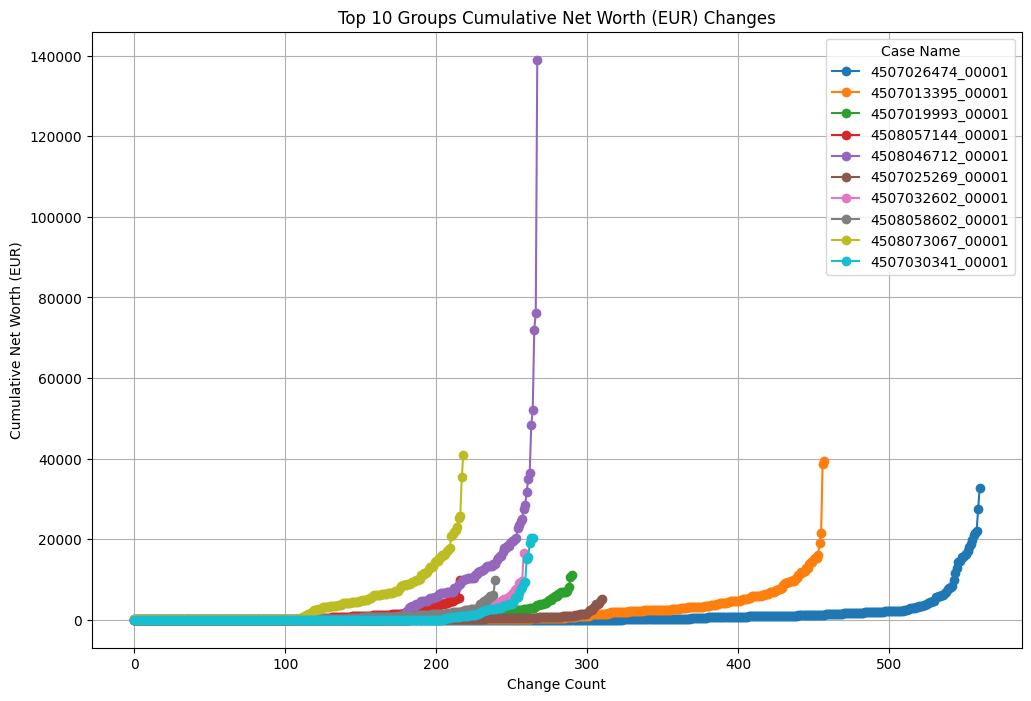

In [26]:
# Plot the temporal changes for the top 10 cases with the most price changes
top_10_groups = filtered_groups.sort_values(ascending=False).head(10)

filtered_log = log[log['case:concept:name'].isin(top_10_groups.index)]

plt.figure(figsize=(12, 8))

for case_name in top_10_groups.index:
    case_data = filtered_log[filtered_log['case:concept:name'] == case_name]
    case_data = case_data.sort_values(by='Cumulative net worth (EUR)')
    plt.plot(case_data['Cumulative net worth (EUR)'].values, marker='o', label=case_name)

plt.title('Top 10 Groups Cumulative Net Worth (EUR) Changes')
plt.xlabel('Change Count')
plt.ylabel('Cumulative Net Worth (EUR)')
plt.legend(title='Case Name')
plt.grid(True)
plt.show()


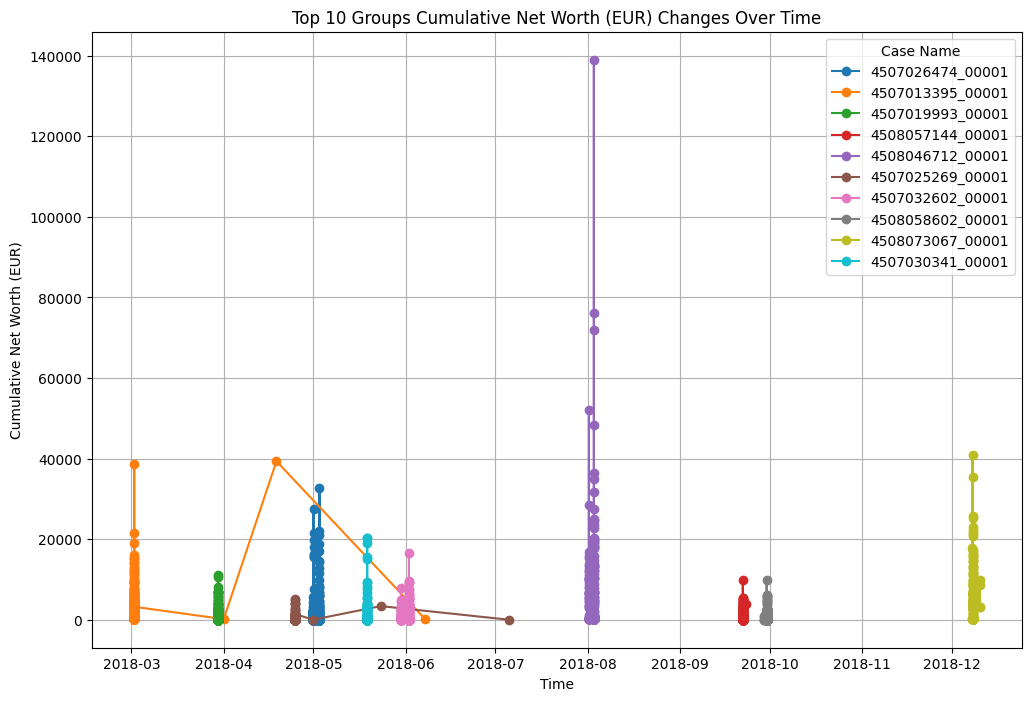

In [27]:
# Historical changes
plt.figure(figsize=(12, 8))

for case_name in top_10_groups.index:
    case_data = filtered_log[filtered_log['case:concept:name'] == case_name]
    case_data = case_data.sort_values(by='time:timestamp')
    plt.plot(case_data['time:timestamp'], case_data['Cumulative net worth (EUR)'], marker='o', label=case_name)

plt.title('Top 10 Groups Cumulative Net Worth (EUR) Changes Over Time')
plt.xlabel('Time')
plt.ylabel('Cumulative Net Worth (EUR)')
plt.legend(title='Case Name')
plt.grid(True)
plt.show()

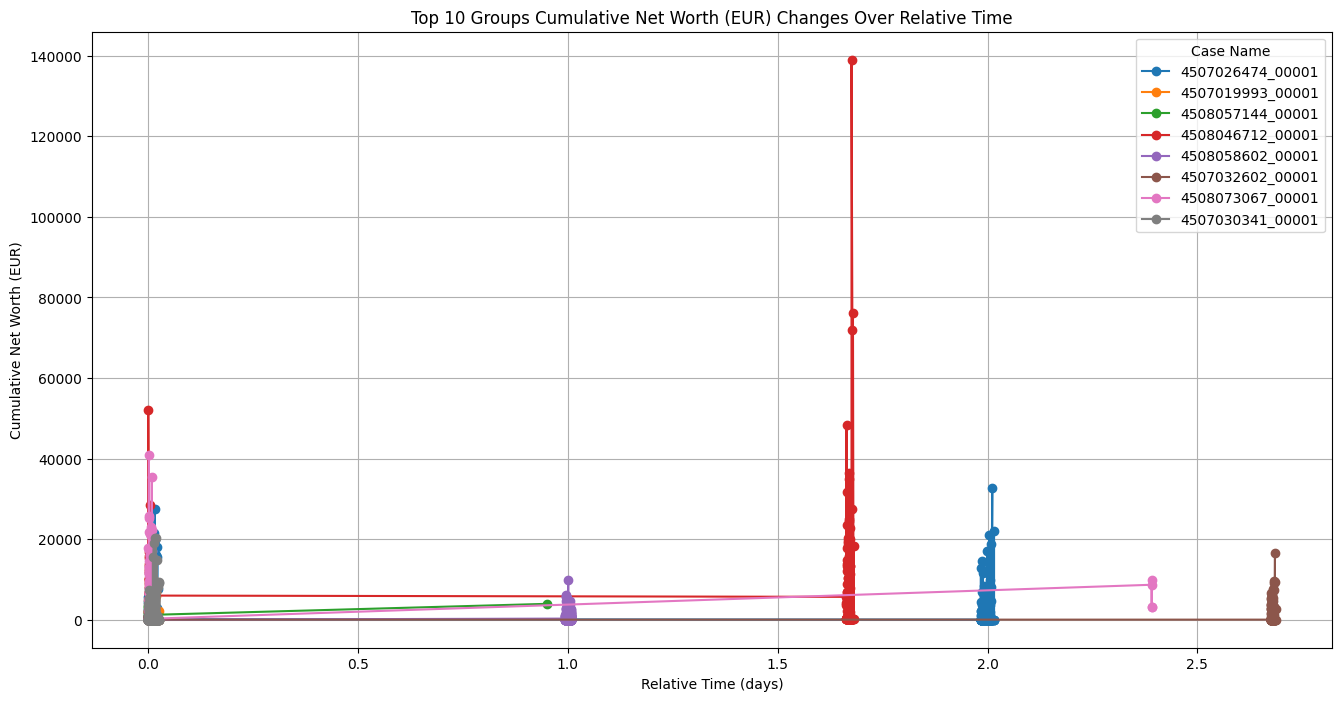

In [28]:
# For a clearer view, the top 8 cases
filtered_groups = filtered_groups[~filtered_groups.index.isin(['4507013395_00001', '4507025269_00001'])]

top_10_groups = filtered_groups.sort_values(ascending=False).head(8)

filtered_log = log[log['case:concept:name'].isin(top_10_groups.index)]

plt.figure(figsize=(16, 8))

for case_name in top_10_groups.index:
    case_data = filtered_log[filtered_log['case:concept:name'] == case_name]
    case_data = case_data.sort_values(by='time:timestamp')
    start_time = case_data['time:timestamp'].iloc[0]
    case_data['relative_time'] = (case_data['time:timestamp'] - start_time).dt.total_seconds() / (60*60*24) 
    plt.plot(case_data['relative_time'], case_data['Cumulative net worth (EUR)'], marker='o', label=case_name)

plt.title('Top 10 Groups Cumulative Net Worth (EUR) Changes Over Relative Time')
plt.xlabel('Relative Time (days)')
plt.ylabel('Cumulative Net Worth (EUR)')
plt.legend(title='Case Name')
plt.grid(True)
plt.show()

In [29]:
# Describe the difference between the maximum and minimum prices
filtered_groups = unique_cnw_counts[unique_cnw_counts > 1]
filtered_log = log[log['case:concept:name'].isin(filtered_groups.index)]
grouped = filtered_log.groupby('case:concept:name')

max_min_diff = grouped['Cumulative net worth (EUR)'].agg(lambda x: x.max() - x.min())

max_min_diff.describe()

count    4.614000e+03
mean     1.220565e+05
std      7.769187e+05
min      1.000000e+00
25%      2.544250e+03
50%      1.012850e+04
75%      5.155900e+04
max      2.889061e+07
Name: Cumulative net worth (EUR), dtype: float64

In [30]:
# Average for all cases Cumulative net worth
log.groupby('case:concept:name')['Cumulative net worth (EUR)'].mean().describe()

count    2.321650e+05
mean     4.341516e+03
std      4.474292e+04
min      1.000000e+00
25%      1.950000e+02
50%      6.020000e+02
75%      2.327000e+03
max      8.833459e+06
Name: Cumulative net worth (EUR), dtype: float64

Due to the extensive data from cases with price changes, it is recommended to store them within the dataset.

In [31]:
# The first and last data points by date
print(log['time:timestamp'].min())
print(log['time:timestamp'].max())

1948-01-26 22:59:00+00:00
2020-04-09 21:59:00+00:00


In [32]:
# Print unique values
log["case:Spend area text"].unique()

array(['CAPEX & SOCS', 'Marketing', 'Enterprise Services',
       'Workforce Services', 'Others', 'Logistics', 'Sales',
       'Real Estate', 'Packaging', 'Additives', 'Specialty Resins',
       'Solvents', 'Trading & End Products', 'Pigments & Colorants',
       'Latex & Monomers', 'Commodity Resins', 'Titanium Dioxides',
       'Spend Area Unidentified', 'Chemicals & Intermediates', 'Energy'],
      dtype=object)

In [33]:
# Change data type string to category for spend area text column
log["case:Spend area text"] = log["case:Spend area text"].astype('category')

In [34]:
# Print unique values
log["case:Company"].unique()

array(['companyID_0000', 'companyID_0001', 'companyID_0002',
       'companyID_0003'], dtype=object)

In [35]:
# Change data type string to category for company column
log["case:Company"] = log["case:Company"].astype('category')

In [36]:
# Print unique values
log["case:Document Type"].unique()

array(['EC Purchase order', 'Standard PO', 'Framework order'],
      dtype=object)

In [37]:
# Change data type string to category for document type column
log["case:Document Type"] = log["case:Document Type"].astype('category')

In [38]:
# Print unique values
log['case:Sub spend area text'].unique()

array(['Facility Management', 'Marketing Support Services',
       'Digital Marketing', 'Office Supplies', 'HR Services',
       'Advertising', 'ICT Software', 'Laboratory Supplies & Services',
       'MRO (components)', 'Third Party Labor', 'Design', 'Consulting',
       'Raw Material', 'Communications', 'Other Logistics Services',
       'Equipment', 'Road Packed', 'Express', 'Travel & expenses',
       'Technical Services', 'Market Research', 'ICT Services',
       'Products for Resale', 'Color Collateral',
       'Real estate brokers or agents',
       'Process Automation & Instrumentation', 'QHSE Services', 'Media',
       'Sales Promotion', 'Labels', 'Plastic Containers & Lids < 30L',
       'Metal Containers & Lids < 30L', 'Extenders', 'Alkyd Resins',
       'Glycol & Ether Solvents', 'Defoamers & Antifoams', 'Surfactants',
       'Driers & Antiskinning Agents', 'Trading products (old structure)',
       'Mixing Machines', 'Plastic Film', 'Biocides', 'Waxes',
       'Colorants',

In [39]:
# Change data type string to category for sub spend area text column
log["case:Sub spend area text"] = log["case:Sub spend area text"].astype('category')

In [40]:
# Print unique values
log['case:Purchasing Document'].unique()

array(['2000000000', '2000000001', '2000000002', ..., '4508076344',
       '4508076345', '4508076346'], dtype=object)

In [41]:
# Change data type string to category for purchasing document column
log["case:Purchasing Document"] = log["case:Purchasing Document"].astype('category')

In [42]:
# Print unique values
log['case:Vendor'].unique()

array(['vendorID_0000', 'vendorID_0001', 'vendorID_0002', ...,
       'vendorID_1970', 'vendorID_1972', 'vendorID_1973'], dtype=object)

In [43]:
# Change data type string to integer for vendor column
log['case:Vendor'] = log['case:Vendor'].str.replace('vendorID_', '').astype(int)

In [44]:
# Print unique values
log['case:Item Type'].unique()

array(['Standard', 'Service', 'Third-party', 'Subcontracting', 'Limit'],
      dtype=object)

In [45]:
# Change data type string to category for item type column
log["case:Item Type"] = log["case:Item Type"].astype('category')

In [46]:
# Print unique values
log['case:Item Category'].unique()

array(['3-way match, invoice before GR', '3-way match, invoice after GR',
       '2-way match'], dtype=object)

In [47]:
# Change data type string to category for item type column
log["case:Item Category"] = log["case:Item Category"].astype('category')

In [48]:
# Print unique values
log['case:Spend classification text'].unique()

array(['NPR', 'OTHER', 'PR'], dtype=object)

In [49]:
# Change data type string to category for spend classification text column
log["case:Spend classification text"] = log["case:Spend classification text"].astype('category')

In [50]:
# Print unique values
log['case:Name'].unique()

array(['vendor_0000', 'vendor_0001', 'vendor_0002', ..., 'vendor_1894',
       'vendor_1896', 'vendor_1897'], dtype=object)

In [51]:
# Change data type string to integer for case name column
log["case:Name"] = log['case:Name'].str.replace('vendor_', '').astype(int)

In [52]:
# Check if the vendor and case name columns are the same
log[log['case:Vendor'] != log['case:Name']]

User                        concept:name  \
7697     user_033          Create Purchase Order Item   
7698     user_033                     Change Quantity   
7699         NONE              Vendor creates invoice   
7700     user_034                Record Goods Receipt   
7701     user_008              Record Invoice Receipt   
...           ...                                 ...   
1595890  user_603  Change Approval for Purchase Order   
1595891  user_602          Create Purchase Order Item   
1595892  user_603  Change Approval for Purchase Order   
1595893  user_602          Create Purchase Order Item   
1595894  user_603  Change Approval for Purchase Order   

         Cumulative net worth (EUR)            time:timestamp  \
7697                        45993.0 2018-01-02 06:41:00+00:00   
7698                        45993.0 2018-01-12 08:49:00+00:00   
7699                        45993.0 2018-01-16 22:59:00+00:00   
7700                        45993.0 2018-01-17 09:07:00+00:00   
7701                        45993.0 2018-01-19 11:36:00+00:00   
...                             ...                       ...   
1595890                      2714.0 2019-01-15 08:51:00+00:00   
1595891                      2714.0 2019-01-15 07:45:00+00:00   
1595892                      2714.0 2019-01-15 08:51:00+00:00   
1595893                      2714.0 2019-01-15 07:45:00+00:00   
1595894                      2714.0 2019-01-15 08:51:00+00:00   

        case:Spend area text    case:Company case:Document Type  \
7697               Additives  companyID_0000        Standard PO   
7698               Additives  companyID_0000        Standard PO   
7699               Additives  companyID_0000        Standard PO   
7700               Additives  companyID_0000        Standard PO   
7701               Additives  companyID_0000        Standard PO   
...                      ...             ...                ...   
1595890          Real Estate  companyID_0003    Framework order   
1595891          Real Estate  companyID_0003    Framework order   
1595892          Real Estate  companyID_0003    Framework order   
1595893          Real Estate  companyID_0003    Framework order   
1595894          Real Estate  companyID_0003    Framework order   

             case:Sub spend area text case:Purchasing Document  case:Vendor  \
7697                      Surfactants               4507000236          116   
7698                      Surfactants               4507000236          116   
7699                      Surfactants               4507000236          116   
7700                      Surfactants               4507000236          116   
7701                      Surfactants               4507000236          116   
...                               ...                      ...          ...   
1595890  Real Estate - To Be Approved               4508076346         1910   
1595891  Real Estate - To Be Approved               4508076346         1910   
1595892  Real Estate - To Be Approved               4508076346         1910   
1595893  Real Estate - To Be Approved               4508076346         1910   
1595894  Real Estate - To Be Approved               4508076346         1910   

        case:Item Type              case:Item Category  \
7697          Standard  3-way match, invoice before GR   
7698          Standard  3-way match, invoice before GR   
7699          Standard  3-way match, invoice before GR   
7700          Standard  3-way match, invoice before GR   
7701          Standard  3-way match, invoice before GR   
...                ...                             ...   
1595890          Limit                     2-way match   
1595891          Limit                     2-way match   
1595892          Limit                     2-way match   
1595893          Limit                     2-way match   
1595894          Limit                     2-way match   

        case:Spend classification text  case:Name  case:GR-Based Inv. Verif.  \
7697            

In [53]:
# Print intersection
filtered_groups = unique_cnw_counts[unique_cnw_counts > 1].index
filtered_log = log[log['case:concept:name'].isin(filtered_groups)]
vendor_name_match = log[log['case:Vendor'] == log['case:Name']]
intersection = filtered_log.merge(vendor_name_match, how='inner')
print(len(log[log['case:concept:name'].isin(filtered_groups)]))
print(len(log[log['case:Vendor'] == log['case:Name']]))
print(len(intersection))

241704
246839
3548


In [54]:
# Print unique values
log['case:Item'].unique()

array(['00001', '00002', '00003', '00004', '00005', '00006', '00007',
       '00008', '00009', '00010', '00011', '00020', '00030', '00040',
       '00050', '00060', '00070', '00080', '00090', '00100', '00110',
       '00120', '00130', '00140', '00150', '00160', '00170', '00180',
       '00190', '00200', '00210', '00220', '00230', '00240', '00250',
       '00260', '00270', '00280', '00290', '00300', '00310', '00320',
       '00330', '00340', '00350', '00360', '00370', '00380', '00390',
       '00400', '00410', '00420', '00430', '00440', '00450', '00460',
       '00470', '00480', '00490', '00500', '00510', '00520', '00530',
       '00540', '00550', '00560', '00570', '00580', '00590', '00600',
       '00610', '00620', '00630', '00640', '00650', '00660', '00670',
       '00680', '00690', '00700', '00710', '00720', '00730', '00740',
       '00750', '00760', '00770', '00780', '00790', '00800', '00810',
       '00820', '00830', '00840', '00850', '00860', '00870', '00880',
       '00890', '009

In [55]:
# Change data type string to integer for case item column
log["case:Item"] = log['case:Item'].astype(int)

In [56]:
# Print unique values
log['case:concept:name'].unique()

array(['2000000000_00001', '2000000001_00001', '2000000002_00001', ...,
       '4508076346_00100', '4508076346_00110', '4508076346_00120'],
      dtype=object)

In [57]:
# Change data type string to category for concept name column
log['case:concept:name'] = log['case:concept:name'].astype('category')

In [58]:
# Rename columns
log = log.rename(columns={'User': 'user', 'concept:name': 'name',
                          'Cumulative net worth (EUR)':'cnw', 'time:timestamp':'time', 
                          'case:Spend area text':'text', 'case:Company':'company', 
                          'case:Purchasing Document':'purchasing', 'case:Vendor':'vendor', 
                          'case:Item Type':'item_type', 'case:Item Category':'item_cat', 
                          'case:Spend classification text':'class_text', 'case:Name':'case_name', 
                          'case:GR-Based Inv. Verif.':'verify', 'case:Item':'case_item', 
                          'case:concept:name':'concept_name', 'case:Goods Receipt':'creceipt',
                          'case:Document Type': 'doc_type', 'case:Sub spend area text': 'spend_area'})

In [59]:
# Find null value for user column
log.user.unique()

array(['batch_00', 'user_000', 'NONE', 'user_001', 'user_002', 'user_004',
       'user_005', 'user_003', 'user_006', 'user_007', 'user_008',
       'user_011', 'user_009', 'user_010', 'user_012', 'user_013',
       'user_014', 'user_015', 'user_018', 'user_016', 'user_019',
       'user_017', 'user_020', 'user_021', 'batch_01', 'user_022',
       'user_023', 'user_024', 'user_025', 'user_026', 'batch_02',
       'user_027', 'user_028', 'batch_03', 'user_029', 'user_030',
       'batch_04', 'user_031', 'user_032', 'user_033', 'user_034',
       'user_035', 'user_036', 'user_037', 'user_038', 'user_039',
       'user_040', 'user_041', 'user_042', 'user_045', 'user_046',
       'user_047', 'user_048', 'user_049', 'user_050', 'user_051',
       'batch_05', 'user_054', 'user_055', 'user_056', 'user_057',
       'user_058', 'user_059', 'user_060', 'user_061', 'user_062',
       'user_063', 'user_064', 'user_066', 'user_067', 'user_068',
       'user_069', 'user_065', 'user_070', 'user_071',

In [60]:
# Change NONE string to NAN value for user column
log.user = log.user.replace('NONE', pd.NA)
log.user.isna().sum()

396423

In [61]:
# Split the user column into user_type and id
mask = log['user'].notna()
masked_data = log[~mask].copy()
unmasked_data = log[mask].copy()
masked_data['user_type'] = None
masked_data['id'] = None
unmasked_data[['user_type', 'id']] = unmasked_data['user'].str.split('_', n=1, expand=True)
unmasked_data['id'] = unmasked_data['id'].astype(int)
merged_data = pd.concat([unmasked_data, masked_data])
log = merged_data.sort_index()
log = log.drop('user', axis=1)
log = log.drop(columns=['id'])
one_hot_encoded = pd.get_dummies(log['user_type'], dummy_na=True)
log = pd.concat([log, one_hot_encoded], axis=1)
log = log.drop(columns=['user_type', np.NAN])

In [62]:
# Check data types
log.dtypes

name                       category
cnw                         float64
time            datetime64[ns, UTC]
text                       category
company                    category
doc_type                   category
spend_area                 category
purchasing                 category
vendor                        int64
item_type                  category
item_cat                   category
class_text                 category
case_name                     int64
verify                         bool
case_item                     int64
concept_name               category
creceipt                       bool
batch                          bool
user                           bool
dtype: object

In [63]:
log

name     cnw  \
0                               SRM: Created   298.0   
1                              SRM: Complete   298.0   
2                     SRM: Awaiting Approval   298.0   
3                    SRM: Document Completed   298.0   
4        SRM: In Transfer to Execution Syst.   298.0   
...                                      ...     ...   
1595890   Change Approval for Purchase Order  2714.0   
1595891           Create Purchase Order Item  2714.0   
1595892   Change Approval for Purchase Order  2714.0   
1595893           Create Purchase Order Item  2714.0   
1595894   Change Approval for Purchase Order  2714.0   

                             time          text         company  \
0       2018-01-02 12:53:00+00:00  CAPEX & SOCS  companyID_0000   
1       2018-01-02 13:53:00+00:00  CAPEX & SOCS  companyID_0000   
2       2018-01-02 13:53:00+00:00  CAPEX & SOCS  companyID_0000   
3       2018-01-02 13:53:00+00:00  CAPEX & SOCS  companyID_0000   
4       2018-01-02 13:53:00+00:00  CAPEX & SOCS  companyID_0000   
...                           ...           ...             ...   
1595890 2019-01-15 08:51:00+00:00   Real Estate  companyID_0003   
1595891 2019-01-15 07:45:00+00:00   Real Estate  companyID_0003   
1595892 2019-01-15 08:51:00+00:00   Real Estate  companyID_0003   
1595893 2019-01-15 07:45:00+00:00   Real Estate  companyID_0003   
1595894 2019-01-15 08:51:00+00:00   Real Estate  companyID_0003   

                  doc_type                    spend_area  purchasing  vendor  \
0        EC Purchase order           Facility Management  2000000000       0   
1        EC Purchase order           Facility Management  2000000000       0   
2        EC Purchase order           Facility Management  2000000000       0   
3        EC Purchase order           Facility Management  2000000000       0   
4        EC Purchase order           Facility Management  2000000000       0   
...                    ...                           ...         ...     ...   
1595890    Framework order  Real Estate - To Be Approved  4508076346    1910   
1595891    Framework order  Real Estate - To Be Approved  4508076346    1910   
1595892    Framework order  Real Estate - To Be Approved  4508076346    1910   
1595893    Framework order  Real Estate - To Be Approved  4508076346    1910   
1595894    Framework order  Real Estate - To Be Approved  4508076346    1910   

        item_type                        item_cat class_text  case_name  \
0        Standard  3-way match, invoice before GR        NPR          0   
1        Standard  3-way match, invoice before GR        NPR          0   
2        Standard  3-way match, invoice before GR        NPR          0   
3        Standard  3-way match, invoice before GR        NPR          0   
4        Standard  3-way match, invoice before GR        NPR          0   
...           ...                             ...        ...        ...   
1595890     Limit                     2-way match        NPR       1834   
1595891     Limit                     2-way match        NPR       1834   
1595892     Limit                     2-way match        NPR       1834   
1595893     Limit                     2-way match        NPR       1834   
1595894     Limit                     2-way match        NPR       1834   

         verify  case_item      concept_name  creceipt  batch   user  
0         False          1  2000000000_00001      True   True  False  
1         False          1  2000000000_00001      True   True  False  
2         False          1  2000000000_00001      True   True  False  
3         False          1  2000000000_00001      True   True  False  
4         False          1  2000000000_00001      True   True  False  
...         ...        ...               ...       ...    ...    ...  
1595890   False        100  4508076346_00100     False  False   True  
1595891   False        110  4508076346_00110     False  False   True  
1595892   False        110  4508076346_00110     False  False

In [64]:
# Analyze the companies
log.company.value_counts()

company
companyID_0000    1533800
companyID_0003       5764
companyID_0001          9
companyID_0002          6
Name: count, dtype: int64

In [65]:
# Delete companyID_0001, companyID_0002
log = log[~log['company'].isin(['companyID_0001', 'companyID_0002'])]

In [66]:
# Analyze document types
log.doc_type.value_counts()

doc_type
Standard PO          1484273
Framework order        33115
EC Purchase order      22176
Name: count, dtype: int64

In [67]:
# One-hot for document type column
log = pd.get_dummies(log, columns=['doc_type'])

In [68]:
for index, count in log['spend_area'].value_counts().items():
    print(f"{index}: {count}")

Products for Resale: 337799
Labels: 289421
Road Packed: 173074
Trading products (old structure): 126661
Metal Containers & Lids < 30L: 116030
Plastic Containers & Lids < 30L: 98667
Other Logistics Services: 53066
Extenders: 37532
Packaging - Other: 37398
Sea: 24550
MRO (components): 15729
Laboratory Supplies & Services: 14123
Surfactants: 12970
Rheology & Thixotropic Agents: 11380
Styrene Acrylics: 9644
Color Collateral: 9179
Business Gifts & Promotional Items: 7881
Colorants: 7844
Paperboard: 7414
Pure Acrylics: 7153
Alkyd Resins: 6423
Customers: 5726
Glycol & Ether Solvents: 5613
Defoamers & Antifoams: 5462
Biocides: 5193
Point of Sales: 5100
Facility Management: 4758
Driers & Antiskinning Agents: 4722
Waxes: 4078
Packaging: 4009
Aliphatic Solvents: 3904
Vinyl Acrylics: 3687
Pallets: 3662
Office Supplies: 3662
Raw Material: 3390
Mixing Machines: 3367
Chloride: 3157
Neutralisation Agents: 2726
Tubes: 2285
Process Automation & Instrumentation: 2015
Commercial Printing: 1988
Additives -

In [69]:
log.spend_area.value_counts().describe()

count       135.000000
mean      11404.177778
std       43821.895012
min           1.000000
25%         282.000000
50%         818.000000
75%        3526.000000
max      337799.000000
Name: count, dtype: float64

In [70]:
threshold = len(log) / 1000  # Calculate the threshold

# Get the value counts for the 'spend_area' column
spend_area_counts = log['spend_area'].value_counts()

# Filter out categories below the threshold
filtered_categories = spend_area_counts[spend_area_counts >= threshold].index

# Filter the DataFrame to keep only rows with spend_area values in filtered_categories
log = log[log['spend_area'].isin(filtered_categories)]

In [71]:
# Print value counts for spend area labels
cat_val = 0
for index, count in log['spend_area'].value_counts().items():
    if count > 0:
        print(f"{index}: {count}")
        cat_val += 1
print('Spend Areas:', cat_val)

Products for Resale: 337799
Labels: 289421
Road Packed: 173074
Trading products (old structure): 126661
Metal Containers & Lids < 30L: 116030
Plastic Containers & Lids < 30L: 98667
Other Logistics Services: 53066
Extenders: 37532
Packaging - Other: 37398
Sea: 24550
MRO (components): 15729
Laboratory Supplies & Services: 14123
Surfactants: 12970
Rheology & Thixotropic Agents: 11380
Styrene Acrylics: 9644
Color Collateral: 9179
Business Gifts & Promotional Items: 7881
Colorants: 7844
Paperboard: 7414
Pure Acrylics: 7153
Alkyd Resins: 6423
Customers: 5726
Glycol & Ether Solvents: 5613
Defoamers & Antifoams: 5462
Biocides: 5193
Point of Sales: 5100
Facility Management: 4758
Driers & Antiskinning Agents: 4722
Waxes: 4078
Packaging: 4009
Aliphatic Solvents: 3904
Vinyl Acrylics: 3687
Office Supplies: 3662
Pallets: 3662
Raw Material: 3390
Mixing Machines: 3367
Chloride: 3157
Neutralisation Agents: 2726
Tubes: 2285
Process Automation & Instrumentation: 2015
Commercial Printing: 1988
Additives -

In [72]:
# Analyze item type column
log.item_type.value_counts()

item_type
Standard          1188439
Service            261156
Third-party         29275
Subcontracting      21409
Limit                1830
Name: count, dtype: int64

In [73]:
# Delete Limit label
log = log[log.item_type != 'Limit']

In [74]:
# One-hot for item type column
log = pd.get_dummies(log, columns=['item_type'])
log = log.drop('item_type_Limit', axis=1)

In [75]:
# Analyze item category column
log.item_cat.value_counts()

item_cat
3-way match, invoice before GR    1190566
3-way match, invoice after GR      309713
2-way match                             0
Name: count, dtype: int64

In [76]:
# One-hot for item category column
log = pd.get_dummies(log, columns=['item_cat'])
log = log.drop('item_cat_2-way match', axis=1)

In [77]:
# Analyze class text column
log.class_text.value_counts()

class_text
PR       823809
NPR      663345
OTHER     13125
Name: count, dtype: int64

In [78]:
# One-hot for class text column
log = pd.get_dummies(log, columns=['class_text'])
log = log.drop('class_text_OTHER', axis=1)

In [79]:
# Show the number of transactions entered for each case
for index, count in log.concept_name.value_counts().items():
    if count > 0:
        print(f"{index}: {count}")

4507027474_00010: 990
4507000440_00010: 923
4507004396_00020: 868
4507000647_00010: 833
4507001973_00010: 745
4507026474_00001: 561
4507000436_00010: 513
4507013227_00001: 509
4507000449_00060: 500
2000000100_00001: 464
4507029298_00001: 461
4507013395_00001: 458
4507027972_00001: 452
4507023700_00001: 418
4507031106_00001: 416
4507025271_00001: 405
4507000684_00010: 399
4507016947_00010: 397
4507032479_00001: 391
4507025985_00001: 387
4507026636_00001: 384
4507031802_00001: 383
4508056372_00001: 381
4507022081_00001: 381
4507034330_00001: 380
4507024602_00001: 379
4508043230_00001: 378
4507019401_00001: 378
4507017814_00001: 376
4508043792_00001: 371
4507027485_00001: 370
4507037775_00001: 370
4508054923_00001: 367
4507021336_00001: 367
4507016136_00001: 366
4507035426_00001: 356
4507040911_00001: 355
4507014546_00001: 352
4508057141_00001: 350
4507028299_00001: 348
4508053640_00001: 346
4507036789_00001: 345
4507012818_00001: 344
4508051804_00001: 343
4507039262_00001: 341
4508052651

In [80]:
# Find the categories with only one occurrence
concept_counts = log['concept_name'].value_counts()
single_occurrence_categories = concept_counts[concept_counts == 1].index
filtered_log = log[log['concept_name'].isin(single_occurrence_categories)]
filtered_log.name.unique()

['Create Purchase Order Item', 'Record Goods Receipt']
Categories (42, object): ['Block Purchase Order Item', 'Cancel Goods Receipt', 'Cancel Invoice Receipt', 'Cancel Subsequent Invoice', ..., 'Set Payment Block', 'Update Order Confirmation', 'Vendor creates debit memo', 'Vendor creates invoice']

In [81]:
# Print case for the categories with only one occurrence
first_rows = filtered_log.groupby('concept_name', observed=False).first()
name_counts = first_rows['name'].value_counts()
for name, count in name_counts.items():
    if count > 0:
        print(f'{name}: {count}')

Create Purchase Order Item: 1938
Record Goods Receipt: 2


In [82]:
# Delete the categories with only one occurrence
log = log[~log['concept_name'].isin(single_occurrence_categories)]
len(log)

1498339

In [83]:
# Print case for the categories with only two occurrence
two_occurrences_categories = concept_counts[concept_counts == 2].index
filtered_log = log[log['concept_name'].isin(two_occurrences_categories)]
second_rows = filtered_log.groupby('concept_name', observed=False).nth(1)
name_counts = second_rows['name'].value_counts()
for name, count in name_counts.items():
    if count > 0:
        print(f'{name}: {count}')


Delete Purchase Order Item: 4582
Record Goods Receipt: 2517
Create Purchase Order Item: 1066
Change Delivery Indicator: 230
Cancel Goods Receipt: 139
Change Price: 70
Change Quantity: 66
Block Purchase Order Item: 53
Change Approval for Purchase Order: 52
Receive Order Confirmation: 7
Change Storage Location: 2
Change payment term: 1


In [84]:
# Check if each case has different purchasing
concept_groups = log.groupby('concept_name', observed=False)
for x in concept_groups['purchasing'].unique():
    if len(x) > 1:
        print(x)

In [85]:
# Check if each case has different item
concept_groups = log.groupby('concept_name', observed=False)
for x in concept_groups['case_item'].unique():
    if len(x) > 1:
        print(x)

In [86]:
# Check unique values
for col in log.columns:
    print(col, len(log[col].unique()))

name 42
cnw 24265
time 158124
text 16
company 1
spend_area 52
purchasing 63585
vendor 1376
case_name 1316
verify 2
case_item 490
concept_name 223928
creceipt 1
batch 2
user 2
doc_type_EC Purchase order 2
doc_type_Framework order 2
doc_type_Standard PO 2
item_type_Service 2
item_type_Standard 2
item_type_Subcontracting 2
item_type_Third-party 2
item_cat_3-way match, invoice after GR 2
item_cat_3-way match, invoice before GR 2
class_text_NPR 2
class_text_PR 2


In [87]:
# Delete constant columns
log = log.drop(columns=['company', 'creceipt'])

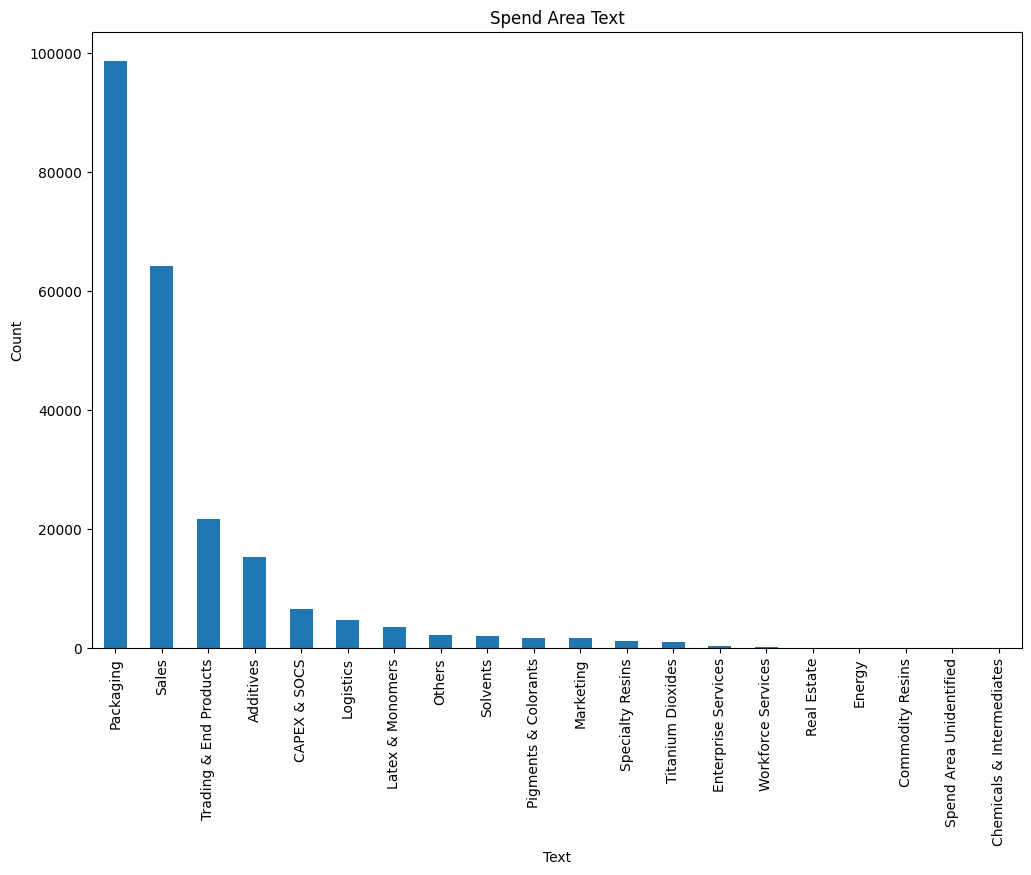

In [88]:
# Analyze spend areas
first_rows = log.groupby('concept_name', observed=False).first().reset_index()
text_counts = first_rows['text'].value_counts()
plt.figure(figsize=(12, 8))
text_counts.plot(kind='bar')
plt.title('Spend Area Text')
plt.xlabel('Text')
plt.ylabel('Count')
plt.show()

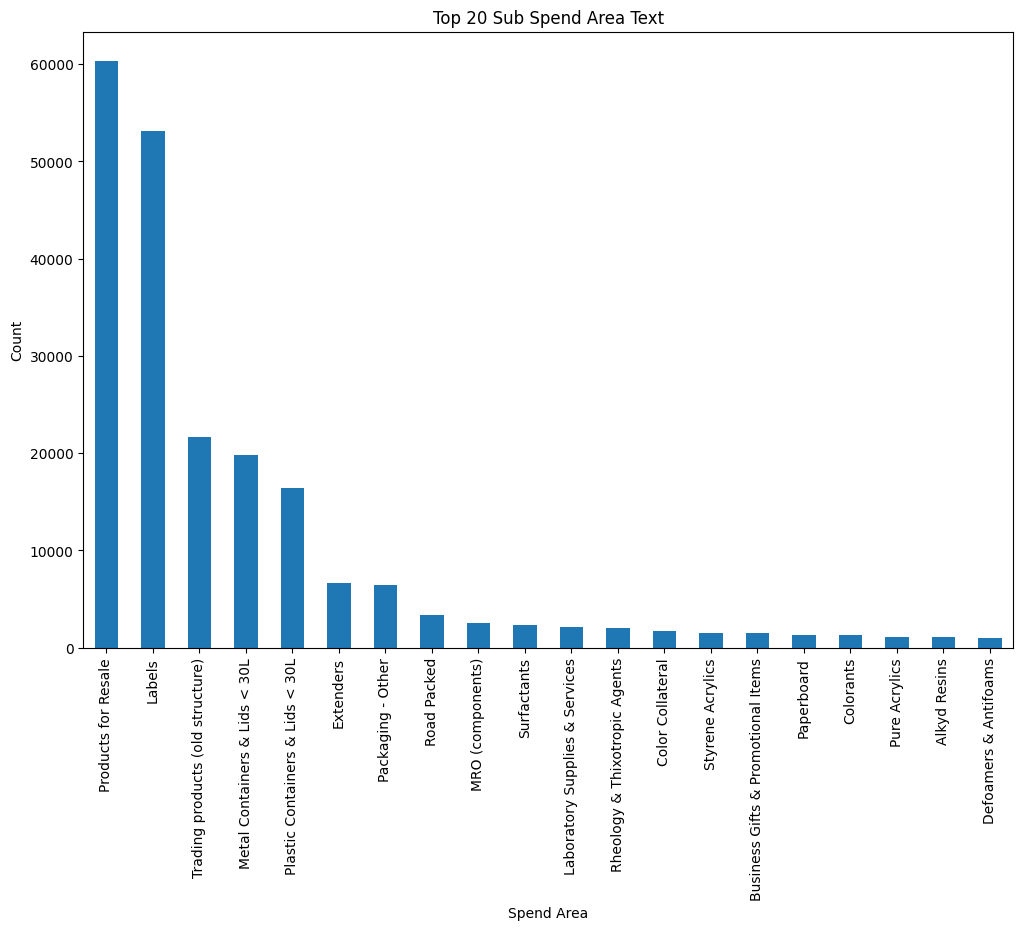

In [89]:
# Analyze sub spend areas
text_counts = first_rows['spend_area'].value_counts()
top_20_text_counts = text_counts.head(20)
plt.figure(figsize=(12, 8))
top_20_text_counts.plot(kind='bar')
plt.title('Top 20 Sub Spend Area Text')
plt.xlabel('Spend Area')
plt.ylabel('Count')
plt.show()

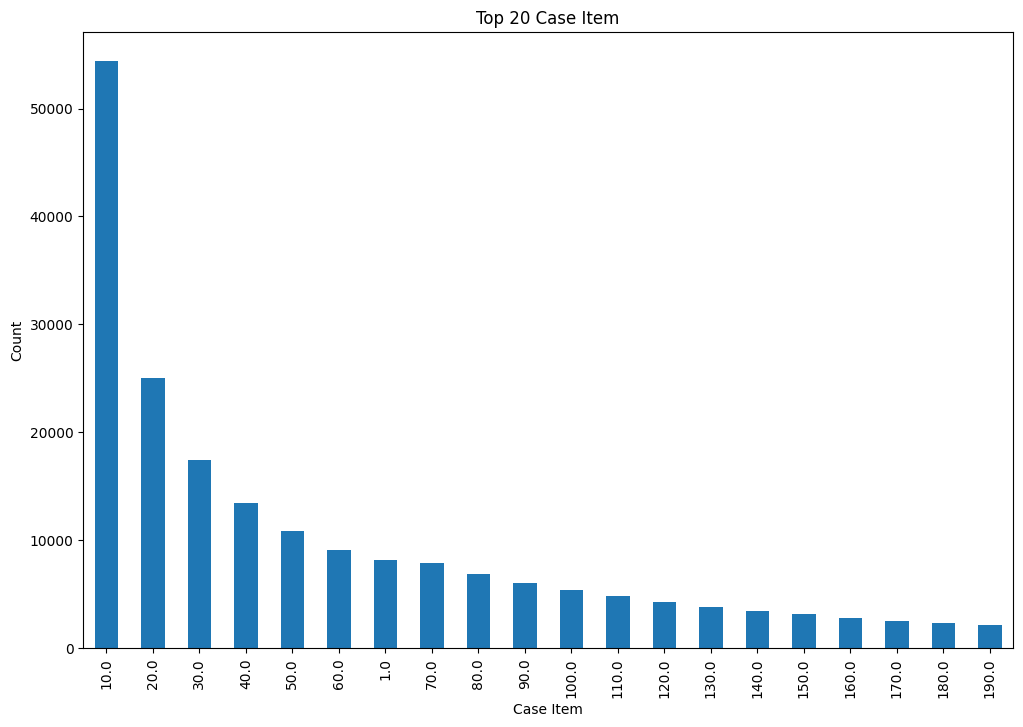

In [90]:
# Analyze items
text_counts = first_rows['case_item'].value_counts()
top_20_text_counts = text_counts.head(20)
plt.figure(figsize=(12, 8))
top_20_text_counts.plot(kind='bar')
plt.title('Top 20 Case Item')
plt.xlabel('Case Item')
plt.ylabel('Count')
plt.show()

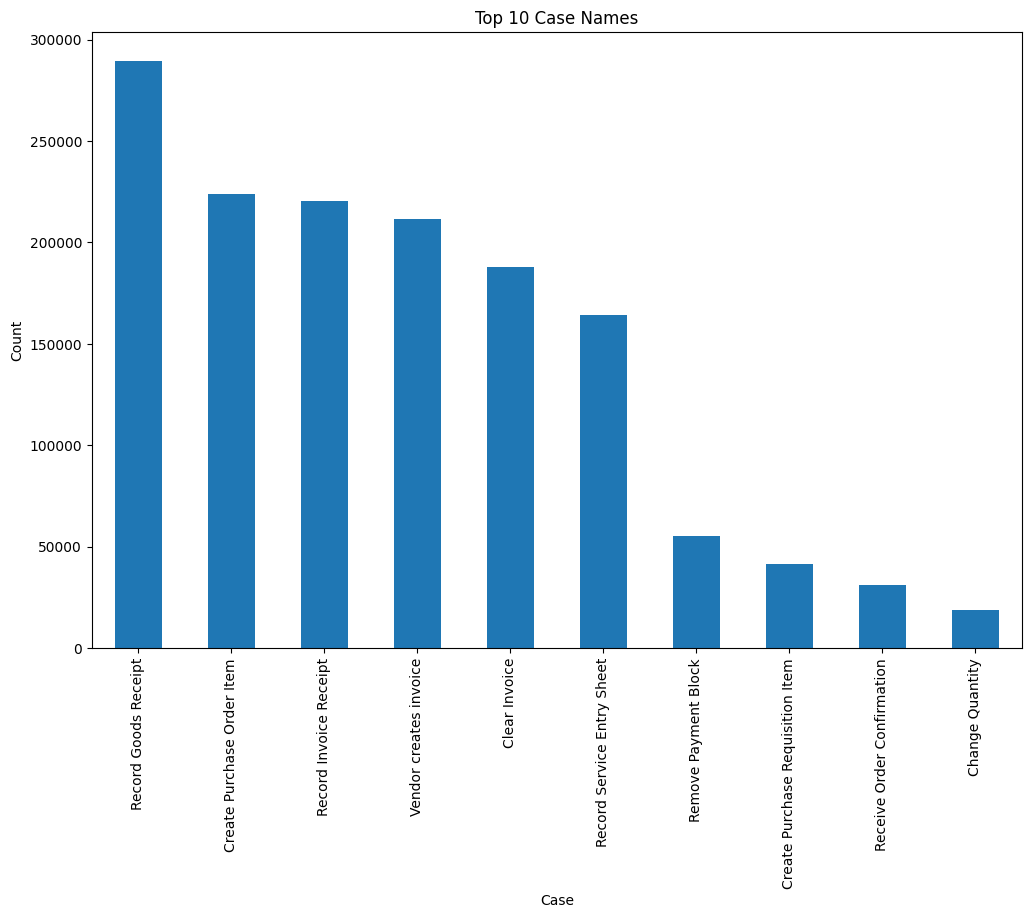

In [91]:
# Analyze case categories
plt.figure(figsize=(12, 8))
log.name.value_counts().head(10).plot(kind='bar')
plt.title('Top 10 Case Names')
plt.xlabel('Case')
plt.ylabel('Count')
plt.show()

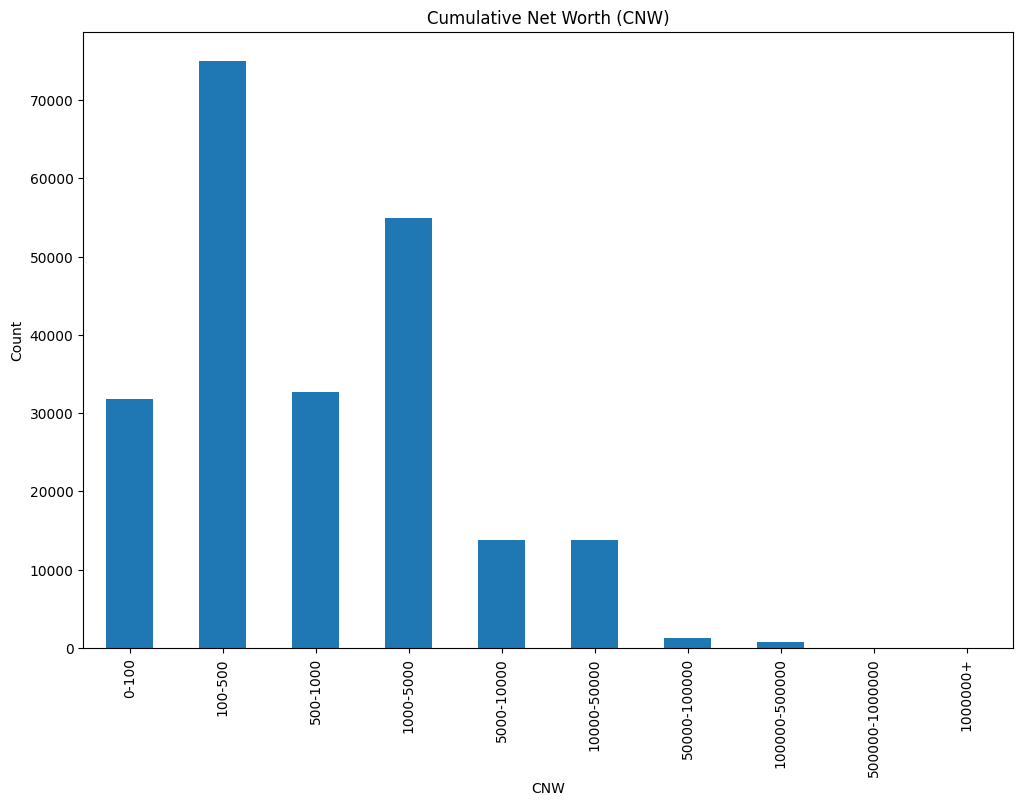

In [92]:
# Analyze First Cumulative Net Worths for all cases
values = first_rows['cnw']
bins = [0, 100, 500, 1000, 5000, 10000, 50000, 100000, 500000, 1000000, values.max()]
labels = ['0-100', '100-500', '500-1000', '1000-5000', '5000-10000', '10000-50000', '50000-100000', '100000-500000', '500000-1000000', '1000000+']
values_binned = pd.cut(values, bins=bins, labels=labels)
value_counts = values_binned.value_counts().sort_index()
plt.figure(figsize=(12, 8))
value_counts.plot(kind='bar')
plt.title('Cumulative Net Worth (CNW)')
plt.xlabel('CNW')
plt.ylabel('Count')
plt.show()

In [93]:
# Analyze years
year = log['time'].dt.year
year.value_counts()

time
2018    1457815
2019      40239
2017        193
2008         45
2001         18
1948         10
1993          9
2016          5
2015          3
2020          2
Name: count, dtype: int64

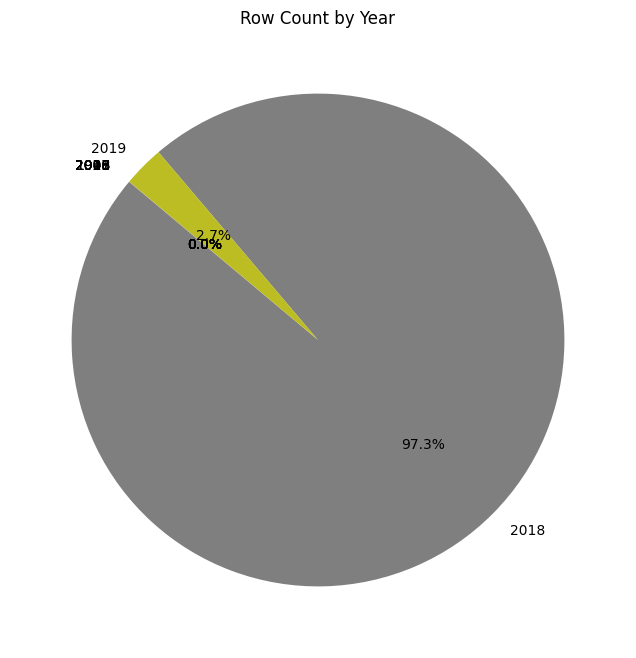

In [94]:
# Pie plot for years
year_counts = year.value_counts().sort_index()
plt.figure(figsize=(10, 8))
plt.pie(year_counts, labels=year_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Row Count by Year')
plt.show()

In [95]:
# Delete the data prior to 2017
log = log[log['time'].dt.year >= 2017]

In [96]:
log.dtypes

name                                                  category
cnw                                                    float64
time                                       datetime64[ns, UTC]
text                                                  category
spend_area                                            category
purchasing                                            category
vendor                                                   int64
case_name                                                int64
verify                                                    bool
case_item                                                int64
concept_name                                          category
batch                                                     bool
user                                                      bool
doc_type_EC Purchase order                                bool
doc_type_Framework order                                  bool
doc_type_Standard PO                                   

In [97]:
# Unique values
log.apply(lambda x: x.nunique())

name                                           42
cnw                                         24265
time                                       158101
text                                           16
spend_area                                     52
purchasing                                  63585
vendor                                       1376
case_name                                    1316
verify                                          2
case_item                                     490
concept_name                               223928
batch                                           2
user                                            2
doc_type_EC Purchase order                      2
doc_type_Framework order                        2
doc_type_Standard PO                            2
item_type_Service                               2
item_type_Standard                              2
item_type_Subcontracting                        2
item_type_Third-party                           2


In [98]:
# Print case labels
for name in log.name.unique():
    print(name)

SRM: Created
SRM: Complete
SRM: Awaiting Approval
SRM: Document Completed
SRM: In Transfer to Execution Syst.
SRM: Ordered
SRM: Change was Transmitted
Create Purchase Order Item
Vendor creates invoice
Record Goods Receipt
Record Invoice Receipt
Clear Invoice
Record Service Entry Sheet
Cancel Goods Receipt
SRM: Transfer Failed (E.Sys.)
Vendor creates debit memo
Cancel Invoice Receipt
SRM: Deleted
Change Price
Remove Payment Block
Change Delivery Indicator
Delete Purchase Order Item
Change Final Invoice Indicator
SRM: Incomplete
SRM: Held
Change Quantity
SRM: Transaction Completed
Receive Order Confirmation
Cancel Subsequent Invoice
Reactivate Purchase Order Item
Update Order Confirmation
Block Purchase Order Item
Change Approval for Purchase Order
Release Purchase Order
Record Subsequent Invoice
Set Payment Block
Create Purchase Requisition Item
Change Storage Location
Change Currency
Change payment term
Change Rejection Indicator
Release Purchase Requisition


In [99]:
# Classify the case transactions
processing = [
    'SRM: Created', 'SRM: Awaiting Approval', 'SRM: In Transfer to Execution Syst.', 'SRM: Ordered', 
    'SRM: Change was Transmitted', 'Record Goods Receipt', 'Record Service Entry Sheet', 'Change Price', 
    'Remove Payment Block', 'Change Delivery Indicator', 'Change Final Invoice Indicator', 'Change Quantity', 
    'Receive Order Confirmation', 'Reactivate Purchase Order Item', 'Update Order Confirmation', 
    'Change Approval for Purchase Order', 'Release Purchase Order', 'Create Purchase Requisition Item', 
    'Change Storage Location', 'Change Currency', 'Change payment term', 'Change Rejection Indicator', 
    'Release Purchase Requisition', 'Create Purchase Order Item'
]

completed = [
    'SRM: Complete', 'SRM: Document Completed', 'Vendor creates invoice', 'Record Invoice Receipt', 'Clear Invoice', 
    'Record Subsequent Invoice', 'Cancel Goods Receipt', 'Cancel Invoice Receipt', 'Delete Purchase Order Item'
]

failed = [
    'SRM: Transfer Failed (E.Sys.)', 'Vendor creates debit memo', 'SRM: Deleted', 'Cancel Subsequent Invoice', 
    'Block Purchase Order Item', 'SRM: Incomplete', 'SRM: Held', 'SRM: Transaction Completed', 'Set Payment Block'
]

def categorize(row):
    if row['name'] in processing:
        return 'continue'
    elif row['name'] in completed:
        return 'failed'
    elif row['name'] in failed:
        return 'successful'
    else:
        print(row['name'])

log['category'] = log.apply(categorize, axis=1)

log

name     cnw  \
0                               SRM: Created   298.0   
1                              SRM: Complete   298.0   
2                     SRM: Awaiting Approval   298.0   
3                    SRM: Document Completed   298.0   
4        SRM: In Transfer to Execution Syst.   298.0   
...                                      ...     ...   
1590020           Record Service Entry Sheet    47.0   
1590021           Record Service Entry Sheet    47.0   
1590022           Record Service Entry Sheet    47.0   
1590023                 Record Goods Receipt  2577.0   
1590024                 Record Goods Receipt  2052.0   

                             time          text           spend_area  \
0       2018-01-02 12:53:00+00:00  CAPEX & SOCS  Facility Management   
1       2018-01-02 13:53:00+00:00  CAPEX & SOCS  Facility Management   
2       2018-01-02 13:53:00+00:00  CAPEX & SOCS  Facility Management   
3       2018-01-02 13:53:00+00:00  CAPEX & SOCS  Facility Management   
4       2018-01-02 13:53:00+00:00  CAPEX & SOCS  Facility Management   
...                           ...           ...                  ...   
1590020 2018-12-31 22:34:00+00:00     Logistics          Road Packed   
1590021 2018-12-31 22:34:00+00:00     Logistics          Road Packed   
1590022 2018-12-31 22:34:00+00:00     Logistics          Road Packed   
1590023 2018-12-31 22:34:00+00:00     Logistics          Road Packed   
1590024 2018-12-31 22:34:00+00:00     Logistics          Road Packed   

         purchasing  vendor  case_name  verify  case_item  ...  \
0        2000000000       0          0   False          1  ...   
1        2000000000       0          0   False          1  ...   
2        2000000000       0          0   False          1  ...   
3        2000000000       0          0   False          1  ...   
4        2000000000       0          0   False          1  ...   
...             ...     ...        ...     ...        ...  ...   
1590020  4508075963     234        229    True          1  ...   
1590021  4508075963     234        229    True          1  ...   
1590022  4508075963     234        229    True          1  ...   
1590023  4508075963     234        229    True          1  ...   
1590024  4508075963     234        229    True          1  ...   

        doc_type_Standard PO  item_type_Service  item_type_Standard  \
0                      False              False                True   
1                      False              False                True   
2                      False              False                True   
3                      False              False                True   
4                      False              False                True   
...                      ...                ...                 ...   
1590020                 True               True               False   
1590021                 True               True               False   
1590022                 True               True               False   
1590023                 True               True               False   
1590024                 True               True               False   

         item_type_Subcontracting  item_type_Third-party  \
0                           False                  False   
1                           False                  False   
2                           False                  False   
3                           False                  False   
4                           False                  False   
...                           ...                    ...   
1590020                     False                  False   
1590021                     False                  False   
1590022                     False                  False   
1590023                     False                  False   
1590024                     False                  False   

         item_cat_3-way match, invoice after GR  \
0                                         False   
1                                

In [100]:
# One-hot for category column
log = pd.get_dummies(log, columns=['category'])

In [101]:
# Set index the time column and sort
log = log.set_index('time')
log = log.sort_index()
log

name      cnw              text  \
time                                                                           
2017-01-05 22:59:00+00:00  Vendor creates invoice    201.0             Sales   
2017-01-05 22:59:00+00:00  Vendor creates invoice     65.0             Sales   
2017-01-05 22:59:00+00:00  Vendor creates invoice     69.0             Sales   
2017-01-05 22:59:00+00:00  Vendor creates invoice    499.0             Sales   
2017-01-05 22:59:00+00:00  Vendor creates invoice    520.0             Sales   
...                                           ...      ...               ...   
2019-10-03 21:59:00+00:00  Vendor creates invoice   2249.0         Additives   
2019-12-05 22:59:00+00:00  Vendor creates invoice    250.0            Others   
2019-12-05 22:59:00+00:00  Vendor creates invoice    362.0            Others   
2020-04-06 21:59:00+00:00  Vendor creates invoice  40904.0  Latex & Monomers   
2020-04-09 21:59:00+00:00  Vendor creates invoice   5033.0         Marketing   

                                      spend_area  purchasing  vendor  \
time                                                                   
2017-01-05 22:59:00+00:00    Products for Resale  4507000846     108   
2017-01-05 22:59:00+00:00    Products for Resale  4507000846     108   
2017-01-05 22:59:00+00:00    Products for Resale  4507000846     108   
2017-01-05 22:59:00+00:00    Products for Resale  4507000846     108   
2017-01-05 22:59:00+00:00    Products for Resale  4507000846     108   
...                                          ...         ...     ...   
2019-10-03 21:59:00+00:00  Neutralisation Agents  4508055808     440   
2019-12-05 22:59:00+00:00              Customers  4508071281     158   
2019-12-05 22:59:00+00:00              Customers  4508071281     158   
2020-04-06 21:59:00+00:00         Vinyl Acrylics  4507019322     183   
2020-04-09 21:59:00+00:00         Point of Sales  4507005744     983   

                           case_name  verify  case_item      concept_name  \
time                                                                        
2017-01-05 22:59:00+00:00        108   False         10  4507000846_00010   
2017-01-05 22:59:00+00:00        108   False         40  4507000846_00040   
2017-01-05 22:59:00+00:00        108   False         60  4507000846_00060   
2017-01-05 22:59:00+00:00        108   False         80  4507000846_00080   
2017-01-05 22:59:00+00:00        108   False         90  4507000846_00090   
...                              ...     ...        ...               ...   
2019-10-03 21:59:00+00:00        427   False         20  4508055808_00020   
2019-12-05 22:59:00+00:00        156   False        140  4508071281_00140   
2019-12-05 22:59:00+00:00        156    True         10  4508071281_00010   
2020-04-06 21:59:00+00:00        181    True         10  4507019322_00010   
2020-04-09 21:59:00+00:00        940    True         10  4507005744_00010   

                           ...  item_type_Standard  item_type_Subcontracting  \
time                       ...                                                 
2017-01-05 22:59:00+00:00  ...                True                     False   
2017-01-05 22:59:00+00:00  ...                True                     False   
2017-01-05 22:59:00+00:00  ...                True                     False   
2017-01-05 22:59:00+00:00  ...                True                     False   
2017-01-05 22:59:00+00:00  ...                True                     False   
...                        ...                 ...                       ...   
2019-10-03 21:59:00+00:00  ...                True                     False   
2019-12-05 22:59:00+00:00  ...                True                     False   
2019-12-05 22:59:00+00:00  ...                True                     False   
2020-04-06 21:59:00+00:00  ...                True                     False   
2020-04-09 21:59:00+00:00  ...               False                     False   

                        

In [102]:
log.dtypes

name                                       category
cnw                                         float64
text                                       category
spend_area                                 category
purchasing                                 category
vendor                                        int64
case_name                                     int64
verify                                         bool
case_item                                     int64
concept_name                               category
batch                                          bool
user                                           bool
doc_type_EC Purchase order                     bool
doc_type_Framework order                       bool
doc_type_Standard PO                           bool
item_type_Service                              bool
item_type_Standard                             bool
item_type_Subcontracting                       bool
item_type_Third-party                          bool
item_cat_3-w

In [103]:
# Train and test split for CatBoost 
concept_counts = log['concept_name'].value_counts()
small_classes = concept_counts[concept_counts < 10].index
large_classes = concept_counts[concept_counts >= 10].index

small_class_data = log[log['concept_name'].isin(small_classes)]
large_class_data = log[log['concept_name'].isin(large_classes)]

train_large, test_large = train_test_split(
    large_class_data.reset_index(), test_size=0.2, stratify=large_class_data['concept_name'])

train = pd.concat([train_large, small_class_data.reset_index()])

train = train.sort_values(by='time')
test = test_large.sort_values(by='time')

train = train.set_index('time')
test = test.set_index('time')

X_train = train.drop(columns=['name'])
y_train = train['name']
X_test = test.drop(columns=['name'])
y_test = test['name']

In [104]:
# Category features for catboost model
cat_features = ['text', 'spend_area', 'purchasing', 'concept_name']

In [105]:
# First classifier model with default parameters
model = CatBoostClassifier(
    cat_features=cat_features,
    iterations=1000,
    depth=6,
    loss_function='MultiClass',
    eval_metric='Accuracy',
    custom_metric=['AUC', 'F1'],
    task_type='GPU',
    devices='0',
    verbose=True
)

model.fit(X_train, y_train)
accuracy = model.score(X_test, y_test)
print("Accuracy:", accuracy)

Learning rate set to 0.285692


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.6118191	total: 863ms	remaining: 14m 22s
1:	total: 1.57s	remaining: 13m 4s
2:	total: 2.28s	remaining: 12m 39s
3:	total: 3s	remaining: 12m 26s
4:	total: 3.72s	remaining: 12m 20s
5:	learn: 0.6019149	total: 4.59s	remaining: 12m 40s
6:	total: 5.31s	remaining: 12m 32s
7:	total: 6.05s	remaining: 12m 29s
8:	total: 6.78s	remaining: 12m 26s
9:	total: 7.52s	remaining: 12m 24s
10:	learn: 0.6279116	total: 8.38s	remaining: 12m 33s
11:	total: 9.11s	remaining: 12m 29s
12:	total: 9.85s	remaining: 12m 27s
13:	total: 10.6s	remaining: 12m 25s
14:	total: 11.3s	remaining: 12m 23s
15:	learn: 0.6367366	total: 12.2s	remaining: 12m 29s
16:	total: 12.9s	remaining: 12m 26s
17:	total: 13.7s	remaining: 12m 24s
18:	total: 14.4s	remaining: 12m 22s
19:	total: 15.1s	remaining: 12m 21s
20:	learn: 0.5874839	total: 16s	remaining: 12m 25s
21:	total: 16.7s	remaining: 12m 23s
22:	total: 17.5s	remaining: 12m 22s
23:	total: 18.2s	remaining: 12m 20s
24:	total: 19s	remaining: 12m 19s
25:	learn: 0.5982132	total: 19.8s

Accuracy: 0.8006882253001987

In [106]:
model.get_all_params()

{'nan_mode': 'Min',
 'gpu_ram_part': 0.95,
 'eval_metric': 'Accuracy',
 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'FeatureFreq:CtrBorderCount=15:CtrBorderType=Median:Prior=0/1'],
 'iterations': 1000,
 'fold_permutation_block': 64,
 'leaf_estimation_method': 'Newton',
 'observations_to_bootstrap': 'TestOnly',
 'random_score_type': 'NormalWithModelSizeDecrease',
 'counter_calc_method': 'SkipTest',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'ctr_history_unit': 'Sample',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'one_hot_max_size': 2,
 'devices': '0',
 'eval_fraction': 0,
 'pinned_memory_bytes': '104857600',
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': False,
 'gpu_cat_features_storage': 'GpuRam',
 'fold_size_loss_normal

In [107]:
# Second model with 2000 iterations and 0.1 learning rate
model1 = CatBoostClassifier(
    cat_features=cat_features,
    iterations=2000,
    depth=6,
    learning_rate=0.1,
    loss_function='MultiClass',
    eval_metric='Accuracy',
    custom_metric=['AUC', 'F1'],
    task_type='GPU',
    devices='0',
    verbose=10
)
model1.fit(X_train, y_train)

accuracy1 = model1.score(X_test, y_test)
print("Accuracy:", accuracy1)

Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.6118191	total: 851ms	remaining: 28m 21s
10:	learn: 0.6168121	total: 8.36s	remaining: 25m 11s
20:	learn: 0.6553536	total: 15.9s	remaining: 24m 55s
30:	learn: 0.6678411	total: 23.4s	remaining: 24m 46s
40:	learn: 0.6750912	total: 30.9s	remaining: 24m 37s
50:	learn: 0.6765883	total: 38.3s	remaining: 24m 25s
60:	learn: 0.6776822	total: 45.8s	remaining: 24m 15s
70:	learn: 0.6786649	total: 53.2s	remaining: 24m 6s
80:	learn: 0.6793914	total: 1m	remaining: 23m 57s
90:	learn: 0.6801711	total: 1m 8s	remaining: 23m 49s
100:	learn: 0.6810109	total: 1m 15s	remaining: 23m 41s
110:	learn: 0.6818116	total: 1m 23s	remaining: 23m 33s
120:	learn: 0.6825759	total: 1m 30s	remaining: 23m 25s
130:	learn: 0.6835914	total: 1m 37s	remaining: 23m 18s
140:	learn: 0.6839764	total: 1m 45s	remaining: 23m 10s
150:	learn: 0.6843991	total: 1m 52s	remaining: 23m 1s
160:	learn: 0.6848008	total: 2m	remaining: 22m 53s
170:	learn: 0.6852845	total: 2m 7s	remaining: 22m 45s
180:	learn: 0.6855812	total: 2m 15s	remai

Accuracy: 0.8659112506119158

In [109]:
# Third model with 4000 iterations and 0.1 learning rate
model2 = CatBoostClassifier(
    cat_features=cat_features,
    iterations=4000,
    depth=6,
    learning_rate=0.1,
    loss_function='MultiClass',
    eval_metric='Accuracy',
    custom_metric=['AUC', 'F1'],
    task_type='GPU',
    verbose=10
)


model2.fit(X_train, y_train)
accuracy2 = model2.score(X_test, y_test)
print("Accuracy:", accuracy2)

Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.6118191	total: 840ms	remaining: 55m 59s
10:	learn: 0.6168121	total: 8.37s	remaining: 50m 34s
20:	learn: 0.6553536	total: 15.9s	remaining: 50m 7s
30:	learn: 0.6678411	total: 23.4s	remaining: 49m 57s
40:	learn: 0.6750912	total: 30.9s	remaining: 49m 47s
50:	learn: 0.6765883	total: 38.4s	remaining: 49m 31s
60:	learn: 0.6776822	total: 45.8s	remaining: 49m 18s
70:	learn: 0.6786649	total: 53.3s	remaining: 49m 7s
80:	learn: 0.6793914	total: 1m	remaining: 48m 56s
90:	learn: 0.6801711	total: 1m 8s	remaining: 48m 44s
100:	learn: 0.6810109	total: 1m 15s	remaining: 48m 34s
110:	learn: 0.6818116	total: 1m 22s	remaining: 48m 25s
120:	learn: 0.6825759	total: 1m 30s	remaining: 48m 17s
130:	learn: 0.6835914	total: 1m 37s	remaining: 48m 8s
140:	learn: 0.6839764	total: 1m 45s	remaining: 47m 59s
150:	learn: 0.6843991	total: 1m 52s	remaining: 47m 49s
160:	learn: 0.6848008	total: 1m 59s	remaining: 47m 39s
170:	learn: 0.6852845	total: 2m 7s	remaining: 47m 32s
180:	learn: 0.6855812	total: 2m 14s	re

Accuracy: 0.8654649120281049

In [106]:
# Fourth model with 2000 iterations and 0.01 learning rate
model3 = CatBoostClassifier(
    cat_features=cat_features,
    iterations=2000,
    depth=6,
    learning_rate=0.01,
    loss_function='MultiClass',
    task_type='GPU',
    devices='0',
    verbose=10
)
model3.fit(X_train, y_train)

accuracy3 = model3.score(X_test, y_test)
print("Accuracy:", accuracy3)

0:	learn: 3.5222597	total: 767ms	remaining: 25m 32s
10:	learn: 2.6150128	total: 7.92s	remaining: 23m 51s
20:	learn: 2.2196001	total: 15.1s	remaining: 23m 38s
30:	learn: 1.9684472	total: 22.3s	remaining: 23m 37s
40:	learn: 1.7884865	total: 29.6s	remaining: 23m 34s
50:	learn: 1.6505363	total: 36.9s	remaining: 23m 29s
60:	learn: 1.5407100	total: 44.2s	remaining: 23m 23s
70:	learn: 1.4510568	total: 51.4s	remaining: 23m 17s
80:	learn: 1.3770192	total: 58.7s	remaining: 23m 9s
90:	learn: 1.3143049	total: 1m 5s	remaining: 23m 3s
100:	learn: 1.2607489	total: 1m 13s	remaining: 22m 58s
110:	learn: 1.2148242	total: 1m 20s	remaining: 22m 51s
120:	learn: 1.1750350	total: 1m 27s	remaining: 22m 44s
130:	learn: 1.1402083	total: 1m 35s	remaining: 22m 37s
140:	learn: 1.1095400	total: 1m 42s	remaining: 22m 30s
150:	learn: 1.0819444	total: 1m 49s	remaining: 22m 23s
160:	learn: 1.0581209	total: 1m 57s	remaining: 22m 16s
170:	learn: 1.0370632	total: 2m 4s	remaining: 22m 9s
180:	learn: 1.0143098	total: 2m 11s

Accuracy: 0.859057793647594

In [107]:
# Fifth model with 2000 iterations, 0.1 learning rate and depth is 8
model4 = CatBoostClassifier(
    cat_features=cat_features,
    iterations=2000,
    depth=8,
    learning_rate=0.1,
    loss_function='MultiClass',
    task_type='GPU',
    devices='0',
    verbose=10
)
model4.fit(X_train, y_train)

accuracy4 = model4.score(X_test, y_test)
print("Accuracy:", accuracy4)

0:	learn: 1.8746293	total: 793ms	remaining: 26m 25s
10:	learn: 1.0842233	total: 8.74s	remaining: 26m 19s
20:	learn: 0.8944069	total: 16.6s	remaining: 26m 2s
30:	learn: 0.7803488	total: 24.5s	remaining: 25m 55s
40:	learn: 0.7378010	total: 32.6s	remaining: 25m 56s
50:	learn: 0.7170213	total: 40.6s	remaining: 25m 51s
60:	learn: 0.7025225	total: 48.6s	remaining: 25m 44s
70:	learn: 0.6940874	total: 56.5s	remaining: 25m 34s
80:	learn: 0.6858067	total: 1m 4s	remaining: 25m 26s
90:	learn: 0.6789614	total: 1m 12s	remaining: 25m 20s
100:	learn: 0.6737272	total: 1m 20s	remaining: 25m 11s
110:	learn: 0.6687941	total: 1m 28s	remaining: 25m 4s
120:	learn: 0.6649801	total: 1m 36s	remaining: 24m 57s
130:	learn: 0.6616805	total: 1m 44s	remaining: 24m 48s
140:	learn: 0.6587100	total: 1m 52s	remaining: 24m 41s
150:	learn: 0.6561326	total: 2m	remaining: 24m 34s
160:	learn: 0.6541017	total: 2m 8s	remaining: 24m 25s
170:	learn: 0.6512409	total: 2m 16s	remaining: 24m 17s
180:	learn: 0.6494421	total: 2m 24s	r

Accuracy: 0.865205747689118

In [109]:
# Sixth model with 2000 iterations, 0.05 learning rate and depth is 6
model5 = CatBoostClassifier(
    cat_features=cat_features,
    iterations=2000,
    depth=6,
    learning_rate=0.05,
    loss_function='MultiClass',
    task_type='GPU',
    devices='0',
    verbose=10
)
model5.fit(X_train, y_train)

accuracy5 = model5.score(X_test, y_test)
print("Accuracy:", accuracy5)

0:	learn: 2.7005044	total: 763ms	remaining: 25m 25s
10:	learn: 1.5321612	total: 8.01s	remaining: 24m 8s
20:	learn: 1.2086951	total: 15.3s	remaining: 23m 58s
30:	learn: 1.0541729	total: 22.5s	remaining: 23m 49s
40:	learn: 0.9571559	total: 29.7s	remaining: 23m 40s
50:	learn: 0.8891987	total: 37.1s	remaining: 23m 35s
60:	learn: 0.8341613	total: 44.3s	remaining: 23m 29s
70:	learn: 0.8004665	total: 51.6s	remaining: 23m 23s
80:	learn: 0.7771466	total: 59s	remaining: 23m 17s
90:	learn: 0.7630081	total: 1m 6s	remaining: 23m 9s
100:	learn: 0.7531832	total: 1m 14s	remaining: 23m 33s
110:	learn: 0.7434859	total: 1m 21s	remaining: 23m 22s
120:	learn: 0.7366272	total: 1m 28s	remaining: 23m 11s
130:	learn: 0.7298506	total: 1m 36s	remaining: 23m
140:	learn: 0.7249268	total: 1m 43s	remaining: 22m 50s
150:	learn: 0.7203134	total: 1m 50s	remaining: 22m 41s
160:	learn: 0.7154661	total: 1m 58s	remaining: 22m 52s
170:	learn: 0.7117827	total: 2m 5s	remaining: 22m 41s
180:	learn: 0.7081545	total: 2m 13s	rema

Accuracy: 0.8665159674028854

In [110]:
# Seventh model with 2000 iterations, 0.2 learning rate and depth is 6
model6 = CatBoostClassifier(
    cat_features=cat_features,
    iterations=2000,
    depth=6,
    learning_rate=0.2,
    loss_function='MultiClass',
    task_type='GPU',
    devices='0',
    verbose=10
)
model6.fit(X_train, y_train)

accuracy6 = model6.score(X_test, y_test)
print("Accuracy:", accuracy6)

0:	learn: 1.2355165	total: 727ms	remaining: 24m 12s
10:	learn: 104.6479922	total: 7.91s	remaining: 23m 50s
20:	learn: 101.5878023	total: 15.2s	remaining: 23m 56s
30:	learn: 97.5965789	total: 23.4s	remaining: 25m 39s
40:	learn: 86.8489769	total: 30.7s	remaining: 25m 2s
50:	learn: 70.9978072	total: 37.9s	remaining: 24m 38s
60:	learn: 49.6924975	total: 45.1s	remaining: 24m 17s
70:	learn: 32.6865646	total: 52.3s	remaining: 24m
80:	learn: 27.9314247	total: 59.5s	remaining: 23m 46s
90:	learn: 23.2075392	total: 1m 6s	remaining: 23m 36s
100:	learn: 17.8438698	total: 1m 14s	remaining: 23m 57s
110:	learn: 9.3467887	total: 1m 22s	remaining: 23m 43s
120:	learn: 8.1962360	total: 1m 29s	remaining: 23m 31s
130:	learn: 7.1803940	total: 1m 36s	remaining: 23m 20s
140:	learn: 6.7184411	total: 1m 43s	remaining: 23m 10s
150:	learn: 6.4100686	total: 1m 52s	remaining: 23m 22s
160:	learn: 5.8947848	total: 2m	remaining: 23m 30s
170:	learn: 5.6554702	total: 2m 7s	remaining: 23m 18s
180:	learn: 5.5569767	total: 

Accuracy: 0.8644858467474875

In [112]:
# Eighth model with 4000 iterations, 0.001 learning rate and depth is 6
model7 = CatBoostClassifier(
    cat_features=cat_features,
    iterations=4000,
    depth=6,
    learning_rate=0.001,
    loss_function='MultiClass',
    task_type='GPU',
    devices='0',
    verbose=10
)
model7.fit(X_train, y_train)

accuracy7 = model7.score(X_test, y_test)
print("Accuracy:", accuracy7)

0:	learn: 3.7160187	total: 732ms	remaining: 48m 48s
10:	learn: 3.5289135	total: 8.86s	remaining: 58m 53s
20:	learn: 3.3791989	total: 17s	remaining: 59m 20s
30:	learn: 3.2537873	total: 24.1s	remaining: 55m 5s
40:	learn: 3.1457018	total: 31.3s	remaining: 52m 55s
50:	learn: 3.0506640	total: 38.4s	remaining: 51m 36s
60:	learn: 2.9658362	total: 45.5s	remaining: 50m 40s
70:	learn: 2.8892586	total: 52.7s	remaining: 49m 59s
80:	learn: 2.8194940	total: 59.8s	remaining: 49m 26s
90:	learn: 2.7554493	total: 1m 6s	remaining: 49m
100:	learn: 2.6962820	total: 1m 14s	remaining: 48m 37s
110:	learn: 2.6413326	total: 1m 21s	remaining: 48m 17s
120:	learn: 2.5900584	total: 1m 28s	remaining: 47m 59s
130:	learn: 2.5420284	total: 1m 35s	remaining: 47m 43s
140:	learn: 2.4968720	total: 1m 42s	remaining: 47m 28s
150:	learn: 2.4542812	total: 1m 49s	remaining: 47m 14s
160:	learn: 2.4140020	total: 1m 56s	remaining: 47m 1s
170:	learn: 2.3758186	total: 2m 4s	remaining: 46m 49s
180:	learn: 2.3395067	total: 2m 11s	rema

In [114]:
# Ninth model with 4000 iterations, 0.005 learning rate and depth is 6
model8 = CatBoostClassifier(
    cat_features=cat_features,
    iterations=4000,
    depth=6,
    learning_rate=0.05,
    loss_function='MultiClass',
    task_type='GPU',
    devices='0',
    verbose=10
)
model8.fit(X_train, y_train)

accuracy8 = model8.score(X_test, y_test)
print("Accuracy:", accuracy8)

0:	learn: 2.7005043	total: 735ms	remaining: 49m
10:	learn: 1.5321614	total: 7.99s	remaining: 48m 17s
20:	learn: 1.2086952	total: 15.3s	remaining: 48m 10s
30:	learn: 1.0541728	total: 22.5s	remaining: 48m 2s
40:	learn: 0.9571559	total: 29.8s	remaining: 47m 52s
50:	learn: 0.8891989	total: 37.1s	remaining: 47m 52s
60:	learn: 0.8341613	total: 44.4s	remaining: 47m 47s
70:	learn: 0.8004664	total: 51.7s	remaining: 47m 42s
80:	learn: 0.7771466	total: 59.1s	remaining: 47m 38s
90:	learn: 0.7630081	total: 1m 5s	remaining: 47m 31s
100:	learn: 0.7531831	total: 1m 14s	remaining: 48m 28s
110:	learn: 0.7434859	total: 1m 21s	remaining: 48m 12s
120:	learn: 0.7366271	total: 1m 29s	remaining: 47m 57s
130:	learn: 0.7298508	total: 1m 36s	remaining: 47m 43s
140:	learn: 0.7249268	total: 1m 43s	remaining: 47m 30s
150:	learn: 0.7203134	total: 1m 50s	remaining: 47m 19s
160:	learn: 0.7154661	total: 1m 57s	remaining: 47m 9s
170:	learn: 0.7117827	total: 2m 5s	remaining: 46m 57s
180:	learn: 0.7081544	total: 2m 12s	re

Accuracy: 0.8674518386270049

In [115]:
# Tenth model with 8000 iterations, 0.001 learning rate and depth is 6
model9 = CatBoostClassifier(
    cat_features=cat_features,
    iterations=8000,
    depth=6,
    learning_rate=0.001,
    loss_function='MultiClass',
    task_type='GPU',
    devices='0',
    verbose=10
)
model9.fit(X_train, y_train)

accuracy9 = model9.score(X_test, y_test)
print("Accuracy:", accuracy9)

0:	learn: 3.7160187	total: 728ms	remaining: 1h 37m 5s
10:	learn: 3.5289135	total: 7.88s	remaining: 1h 35m 20s
20:	learn: 3.3791996	total: 16s	remaining: 1h 46m 25s
30:	learn: 3.2537869	total: 23.1s	remaining: 1h 42m 25s
40:	learn: 3.1457021	total: 30.3s	remaining: 1h 40m 24s
50:	learn: 3.0506644	total: 37.4s	remaining: 1h 39m 8s
60:	learn: 2.9658359	total: 44.6s	remaining: 1h 38m 15s
70:	learn: 2.8892588	total: 52.7s	remaining: 1h 40m 54s
80:	learn: 2.8194939	total: 1m	remaining: 1h 42m 54s
90:	learn: 2.7554492	total: 1m 8s	remaining: 1h 44m 28s
100:	learn: 2.6962817	total: 1m 16s	remaining: 1h 43m 16s
110:	learn: 2.6413327	total: 1m 24s	remaining: 1h 44m 28s
120:	learn: 2.5900584	total: 1m 31s	remaining: 1h 43m 25s
130:	learn: 2.5420282	total: 1m 38s	remaining: 1h 42m 31s
140:	learn: 2.4968718	total: 1m 45s	remaining: 1h 41m 43s
150:	learn: 2.4542812	total: 1m 53s	remaining: 1h 42m 38s
160:	learn: 2.4140018	total: 2m	remaining: 1h 41m 54s
170:	learn: 2.3758188	total: 2m 8s	remaining: 

Accuracy: 0.852362714890431

In [116]:
# Eleventh model with 16000 iterations, 0.001 learning rate and depth is 6
model10 = CatBoostClassifier(
    cat_features=cat_features,
    iterations=16000,
    depth=6,
    learning_rate=0.001,
    loss_function='MultiClass',
    task_type='GPU',
    devices='0',
    verbose=10
)
model10.fit(X_train, y_train)

accuracy10 = model10.score(X_test, y_test)
print("Accuracy:", accuracy10)

0:	learn: 3.7160191	total: 732ms	remaining: 3h 15m 7s
10:	learn: 3.5289135	total: 7.86s	remaining: 3h 10m 19s
20:	learn: 3.3791996	total: 15s	remaining: 3h 10m 1s
30:	learn: 3.2537866	total: 22.1s	remaining: 3h 9m 54s
40:	learn: 3.1457021	total: 29.2s	remaining: 3h 9m 44s
50:	learn: 3.0506640	total: 36.4s	remaining: 3h 9m 37s
60:	learn: 2.9658366	total: 43.5s	remaining: 3h 9m 29s
70:	learn: 2.8892586	total: 50.6s	remaining: 3h 9m 20s
80:	learn: 2.8194939	total: 57.8s	remaining: 3h 9m 11s
90:	learn: 2.7554490	total: 1m 4s	remaining: 3h 9m 3s
100:	learn: 2.6962818	total: 1m 12s	remaining: 3h 8m 56s
110:	learn: 2.6413329	total: 1m 19s	remaining: 3h 8m 49s
120:	learn: 2.5900589	total: 1m 26s	remaining: 3h 8m 43s
130:	learn: 2.5420282	total: 1m 33s	remaining: 3h 8m 36s
140:	learn: 2.4968718	total: 1m 40s	remaining: 3h 8m 29s
150:	learn: 2.4542814	total: 1m 47s	remaining: 3h 8m 22s
160:	learn: 2.4140020	total: 1m 55s	remaining: 3h 11m 4s
170:	learn: 2.3758184	total: 2m 2s	remaining: 3h 10m 4

Accuracy: 0.859907276758718

In [105]:
# Final model with 4000 iterations, 0.005 learning rate and depth is 6
model_final = CatBoostClassifier(
    cat_features=cat_features,
    iterations=4000,
    depth=6,
    learning_rate=0.05,
    loss_function='MultiClass',
    task_type='GPU',
    devices='0',
    verbose=10
)
model_final.fit(X_train, y_train)

0:	learn: 2.7005524	total: 827ms	remaining: 55m 5s
10:	learn: 1.5307791	total: 8.78s	remaining: 53m 5s
20:	learn: 1.2086920	total: 16.8s	remaining: 52m 57s
30:	learn: 1.0545963	total: 24.8s	remaining: 52m 54s
40:	learn: 0.9566109	total: 32.8s	remaining: 52m 46s
50:	learn: 0.8862539	total: 40.9s	remaining: 52m 43s
60:	learn: 0.8325915	total: 48.9s	remaining: 52m 39s
70:	learn: 0.8002379	total: 57s	remaining: 52m 33s
80:	learn: 0.7765939	total: 1m 5s	remaining: 52m 30s
90:	learn: 0.7630864	total: 1m 13s	remaining: 52m 21s
100:	learn: 0.7528206	total: 1m 22s	remaining: 53m 38s
110:	learn: 0.7442181	total: 1m 31s	remaining: 54m 37s
120:	learn: 0.7362253	total: 1m 41s	remaining: 56m 46s
130:	learn: 0.7292881	total: 1m 54s	remaining: 59m 40s
140:	learn: 0.7233913	total: 2m 2s	remaining: 58m 54s
150:	learn: 0.7173777	total: 2m 12s	remaining: 1h 24s
160:	learn: 0.7131991	total: 2m 22s	remaining: 1h 32s
170:	learn: 0.7087319	total: 2m 30s	remaining: 59m 48s
180:	learn: 0.7055424	total: 2m 38s	r

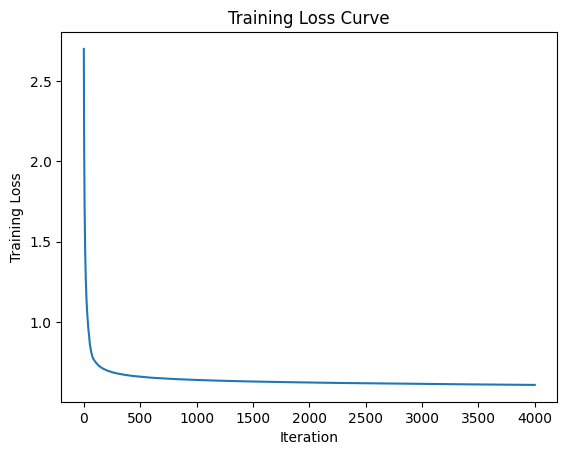

In [111]:
train_loss_data = model_final.get_evals_result()['learn']['MultiClass']

# Plot the training loss graph
plt.plot(train_loss_data)
plt.xlabel('Iteration')
plt.ylabel('Training Loss')
plt.title('Training Loss Curve')
plt.show()

In [112]:
y_pred = model_final.predict(X_test)

In [113]:
model_final.get_feature_importance()

array([1.37458817e+00, 1.24085255e+00, 1.78085073e+00, 2.95507128e+00,
       1.85551701e+00, 1.63312933e+00, 4.65145752e-02, 5.96227471e-01,
       4.70387294e+00, 5.96031294e+00, 5.56873537e+01, 1.85350372e-02,
       3.72826023e-03, 4.41570104e-03, 1.82878270e-01, 3.98964786e-02,
       5.75654199e-02, 8.48502405e-02, 1.13278640e-01, 4.73595965e-02,
       1.03075656e-01, 1.37410206e-01, 9.66774705e+00, 1.16877293e+01,
       1.72394987e-02])

In [131]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=True)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=True)
f1 = f1_score(y_test, y_pred, average='weighted')

print("Model Evaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"F1-score (weighted): {f1:.4f}")

Model Evaluation Metrics:
Accuracy: 0.8655
Precision (weighted): 0.8528
Recall (weighted): 0.8655
F1-score (weighted): 0.8503


In [154]:
print("Predict unique values:", len(np.unique(y_pred)))
np.unique(y_pred)

Predict unique values: 34


array(['Block Purchase Order Item', 'Cancel Goods Receipt',
       'Cancel Invoice Receipt', 'Cancel Subsequent Invoice',
       'Change Approval for Purchase Order', 'Change Delivery Indicator',
       'Change Price', 'Change Quantity', 'Clear Invoice',
       'Create Purchase Order Item', 'Create Purchase Requisition Item',
       'Delete Purchase Order Item', 'Reactivate Purchase Order Item',
       'Receive Order Confirmation', 'Record Goods Receipt',
       'Record Invoice Receipt', 'Record Service Entry Sheet',
       'Record Subsequent Invoice', 'Release Purchase Order',
       'Remove Payment Block', 'SRM: Awaiting Approval',
       'SRM: Change was Transmitted', 'SRM: Complete', 'SRM: Created',
       'SRM: Deleted', 'SRM: Document Completed',
       'SRM: In Transfer to Execution Syst.', 'SRM: Incomplete',
       'SRM: Ordered', 'SRM: Transfer Failed (E.Sys.)',
       'Set Payment Block', 'Update Order Confirmation',
       'Vendor creates debit memo', 'Vendor creates invoice

In [150]:
print("Test unique values:", len(y_test.unique()))
np.array(y_test.unique())

Test unique values: 37


array(['Vendor creates invoice', 'Vendor creates debit memo',
       'Create Purchase Order Item', 'SRM: Awaiting Approval',
       'SRM: Ordered', 'Cancel Goods Receipt', 'Record Goods Receipt',
       'Record Service Entry Sheet', 'Create Purchase Requisition Item',
       'Change Price', 'SRM: Created', 'SRM: Change was Transmitted',
       'SRM: Complete', 'SRM: In Transfer to Execution Syst.',
       'Record Invoice Receipt', 'Change Quantity',
       'SRM: Document Completed', 'Change Approval for Purchase Order',
       'Change Delivery Indicator', 'Clear Invoice',
       'Remove Payment Block', 'Receive Order Confirmation',
       'Delete Purchase Order Item', 'Cancel Subsequent Invoice',
       'Cancel Invoice Receipt', 'Reactivate Purchase Order Item',
       'Release Purchase Order', 'Block Purchase Order Item',
       'Record Subsequent Invoice', 'Update Order Confirmation',
       'SRM: Deleted', 'Change Storage Location', 'Set Payment Block',
       'Change Final Invoice 

In [155]:
difference_array = np.setdiff1d(y_pred, y_test.unique())

# Print the difference array
print("Predicted labels that are not present in the test data: \n", difference_array)

Predicted labels that are not present in the test data: 
 ['SRM: Incomplete']


In [161]:
count = np.count_nonzero(y_pred == 'SRM: Incomplete')
count

1

In [156]:
difference_array1 = np.setdiff1d(y_test.unique(), y_pred)

# Print the difference array
print("Test labels that are not present in the predict data: \n", difference_array1)

Test labels that are not present in the predict data: 
 ['Change Currency' 'Change Final Invoice Indicator'
 'Change Storage Location' 'SRM: Transaction Completed']
